# Cafe & restaurants with seating capacity

This data is part of the City of Melbourne's Land Use and Employment Census. The data covers the period 2002 to 2022. It shows business establishments and their trade names, business addresses, industry (ANZSIC4) classification, restaurant seating capacity (by indoor/outdoor classification), location, and CLUE block and sub-area designations. Data comes from CITY OF MELBOURNE [https://data.melbourne.vic.gov.au/explore/dataset/cafes-and-restaurants-with-seating-capacity/information/]

`imports`

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime
import geopandas as gp
import shapely
import fiona


In [2]:
%matplotlib inline

In [3]:
plt.rcParams["figure.figsize"] = (10, 5)


In [4]:
saved_style_state = matplotlib.rcParams.copy()  # give us a style state to go back to


In [5]:
if os.path.isfile("cafes-and-restaurants-with-seating-capacity.csv"):
    filepath = "cafes-and-restaurants-with-seating-capacity.csv"
    print("loading from file")
else:
    filepath = "..."
    print("loading from the internet")

seat_data = pd.read_csv(filepath)
print("done")

shp_file_name = "/Users/mac/1161/S_Data/municipal-boundary/municipal-boundary.shp"
zip_file_name = "nsw_locality_polygon_shp.zip"
web_file_path = (
"https://data.gov.au/data/dataset/"
"91e70237-d9d1-4719-a82f-e71b811154c6/resource/"
"5e295412-357c-49a2-98d5-6caf099c2339/download/"
"nsw_locality_polygon_shp.zip"
)

%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)

def unzip_zipfile(zipped_file_path, put_it_here="."):
    import zipfile
    zip_of_suburbs = zipfile.ZipFile(zipped_file_path, 'r')
    zip_of_suburbs.extractall(put_it_here)
    zip_of_suburbs.close()


loading from file
done


In [6]:
seat_data.head()


,Census year,Block ID,Property ID,Base property ID,Building address,CLUE small area,Trading name,Business address,Industry (ANZSIC4) code,Industry (ANZSIC4) description,Seating type,Number of seats,Longitude,Latitude,location
0,2017,6,578324,573333,2 Swanston Street MELBOURNE 3000,Melbourne (CBD),Transport Hotel,"Tenancy 29, Ground , 2 Swanston Street MELBOUR...",4520,"Pubs, Taverns and Bars",Seats - Indoor,230,144.969942,-37.817778,"-37.817777826050005, 144.96994164279243"
1,2017,6,578324,573333,2 Swanston Street MELBOURNE 3000,Melbourne (CBD),Transport Hotel,"Tenancy 29, Ground , 2 Swanston Street MELBOUR...",4520,"Pubs, Taverns and Bars",Seats - Outdoor,120,144.969942,-37.817778,"-37.817777826050005, 144.96994164279243"
2,2017,11,103957,103957,517-537 Flinders Lane MELBOURNE 3000,Melbourne (CBD),Altius Coffee Brewers,"Shop , Ground , 517 Flinders Lane MELBOURNE 3000",4512,Takeaway Food Services,Seats - Outdoor,4,144.956486,-37.819875,"-37.819875445799994, 144.95648638781466"
3,2017,11,103957,103957,517-537 Flinders Lane MELBOURNE 3000,Melbourne (CBD),Five & Dime Bagel,16 Flinders Lane MELBOURNE 3000,1174,Bakery Product Manufacturing (Non-factory based),Seats - Indoor,14,144.956486,-37.819875,"-37.819875445799994, 144.95648638781466"
4,2017,11,103985,103985,562-564 Flinders Street MELBOURNE 3000,Melbourne (CBD),YHA Melbourne Central,562-564 Flinders Street MELBOURNE 3000,4400,Accommodation,Seats - Indoor,43,144.955635,-37.820595,"-37.82059511593975, 144.9556348088"


In [7]:
seat_data.sample(5)


,Census year,Block ID,Property ID,Base property ID,Building address,CLUE small area,Trading name,Business address,Industry (ANZSIC4) code,Industry (ANZSIC4) description,Seating type,Number of seats,Longitude,Latitude,location
18295,2016,93,105473,105473,410-420 La Trobe Street MELBOURNE 3000,Melbourne (CBD),Cafenatics,"Part Ground , 414 La Trobe Street MELBOURNE 3000",4511,Cafes and Restaurants,Seats - Indoor,38,144.957122,-37.811238,"-37.81123777600966, 144.95712245121337"
1303,2018,28,102063,102060,45 Collins Street MELBOURNE 3000,Melbourne (CBD),Nashi,"Shop 45, 45 Collins Street MELBOURNE 3000",4512,Takeaway Food Services,Seats - Outdoor,10,144.972626,-37.814305,"-37.81430518125, 144.97262557265284"
21669,2021,21,579252,579252,559-587 Collins Street MELBOURNE VIC 3000,Melbourne (CBD),Buddabah,"Tenancy 1-2, 567 Collins Street MELBOURNE VIC ...",4511,Cafes and Restaurants,Seats - Indoor,26,144.955725,-37.819020,"-37.8190200855, 144.95572468102446"
49012,2021,207,106143,106143,303 Lygon Street CARLTON VIC 3053,Carlton,Tiamo Coffee,303 Lygon Street CARLTON VIC 3053,4511,Cafes and Restaurants,Seats - Indoor,50,144.967090,-37.798221,"-37.798221186350005, 144.9670899577839"
58917,2016,1105,598590,598590,720-750 Collins Street DOCKLANDS 3008,Docklands,Simmer Pronto,"Level 2, 750 Collins Street DOCKLANDS 3008",4511,Cafes and Restaurants,Seats - Indoor,72,NaN,NaN,NaN


In [8]:
seat_data.columns

Index(['Census year', 'Block ID', 'Property ID', 'Base property ID',
       'Building address', 'CLUE small area', 'Trading name',
       'Business address', 'Industry (ANZSIC4) code',
       'Industry (ANZSIC4) description', 'Seating type', 'Number of seats',
       'Longitude', 'Latitude', 'location'],
      dtype='object')

In [9]:
row_one = seat_data.iloc[1]
row_one


Census year                                                                    2017
Block ID                                                                          6
Property ID                                                                  578324
Base property ID                                                             573333
Building address                                   2 Swanston Street MELBOURNE 3000
CLUE small area                                                     Melbourne (CBD)
Trading name                                                        Transport Hotel
Business address                  Tenancy 29, Ground , 2 Swanston Street MELBOUR...
Industry (ANZSIC4) code                                                        4520
Industry (ANZSIC4) description                               Pubs, Taverns and Bars
Seating type                                                        Seats - Outdoor
Number of seats                                                             

In [10]:
row_one["Number of seats"]


120

In [11]:
row_one["Industry (ANZSIC4) description"]

'Pubs, Taverns and Bars'

In [12]:
seat_data["Seating type"]

0         Seats - Indoor
1        Seats - Outdoor
2        Seats - Outdoor
3         Seats - Indoor
4         Seats - Indoor
              ...       
60050     Seats - Indoor
60051    Seats - Outdoor
60052     Seats - Indoor
60053     Seats - Indoor
60054    Seats - Outdoor
Name: Seating type, Length: 60055, dtype: object

This chart shows the total years counted and the frequency of occurrence

<Axes: >

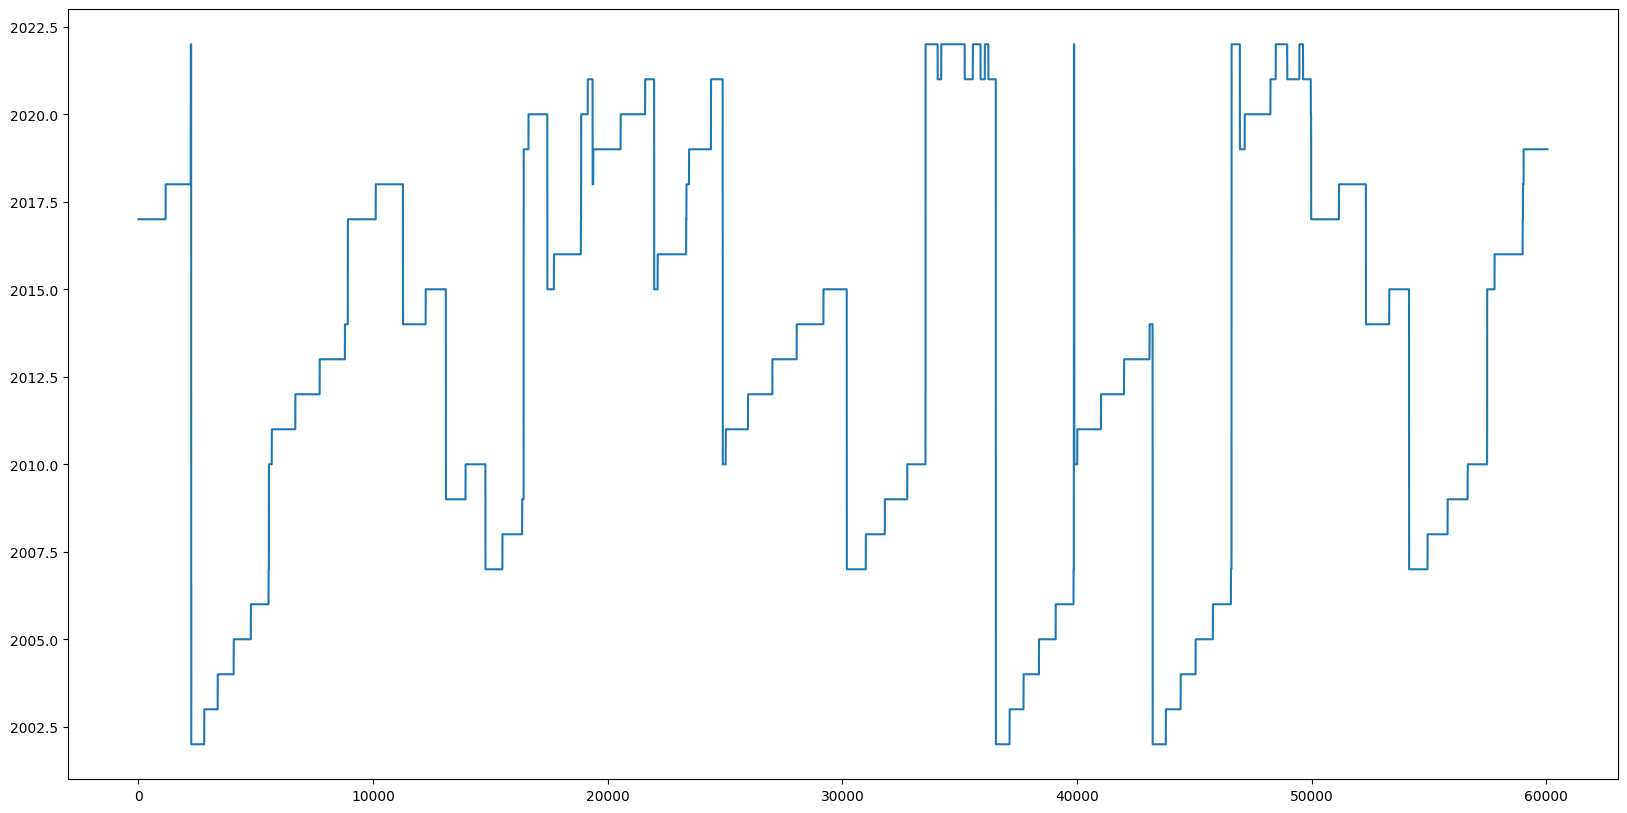

In [13]:
seat_data["Census year"].plot()

This chart shows the total number of seats counted.

<Axes: >

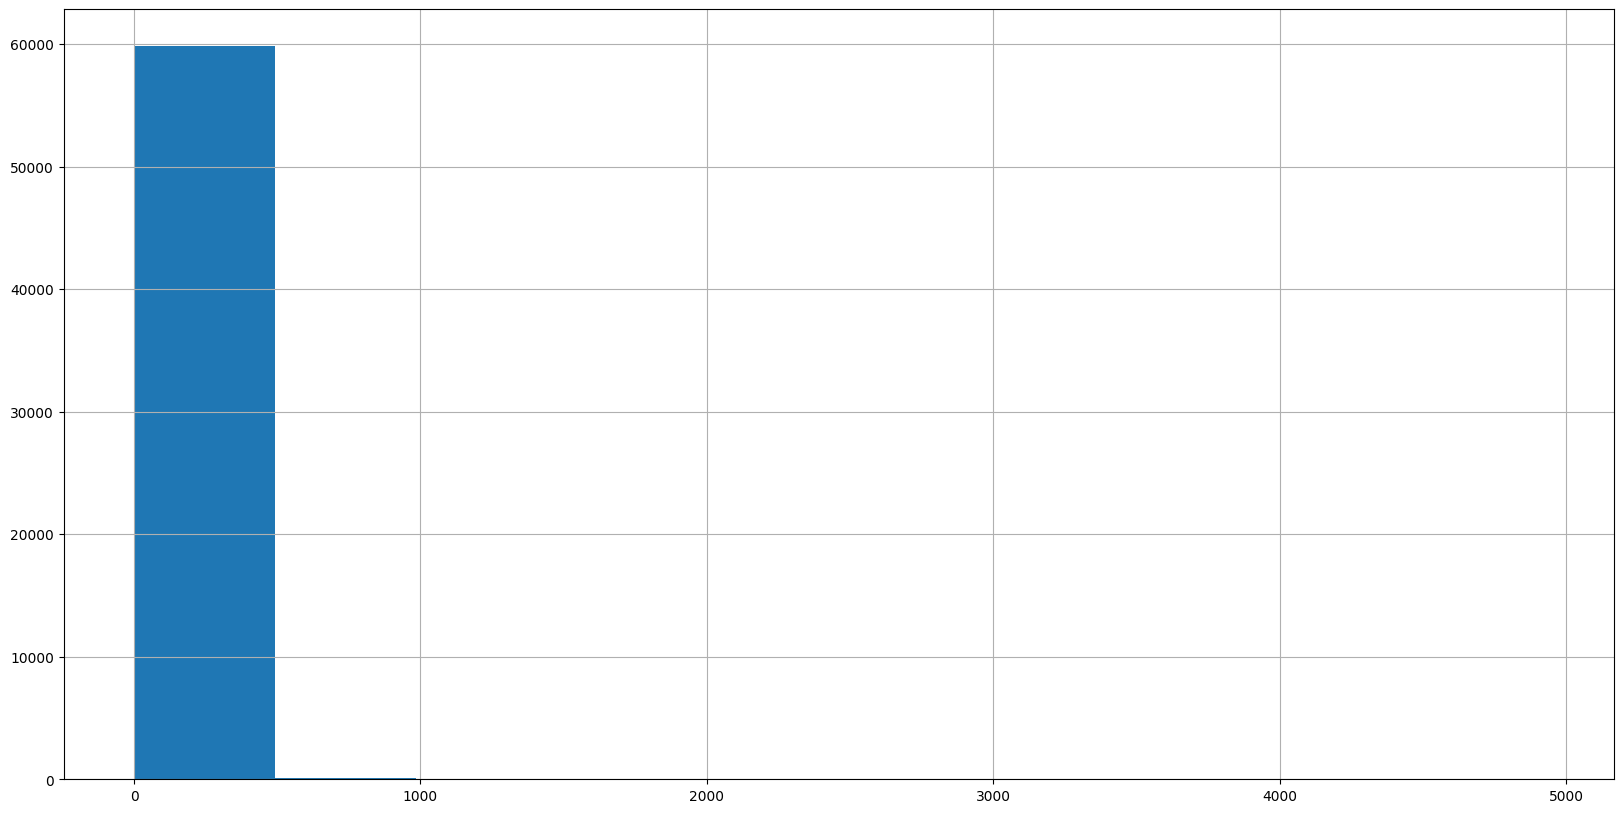

In [ ]:
seat_data["Number of seats"].hist()

Number of seats counted in each year period

<Axes: >

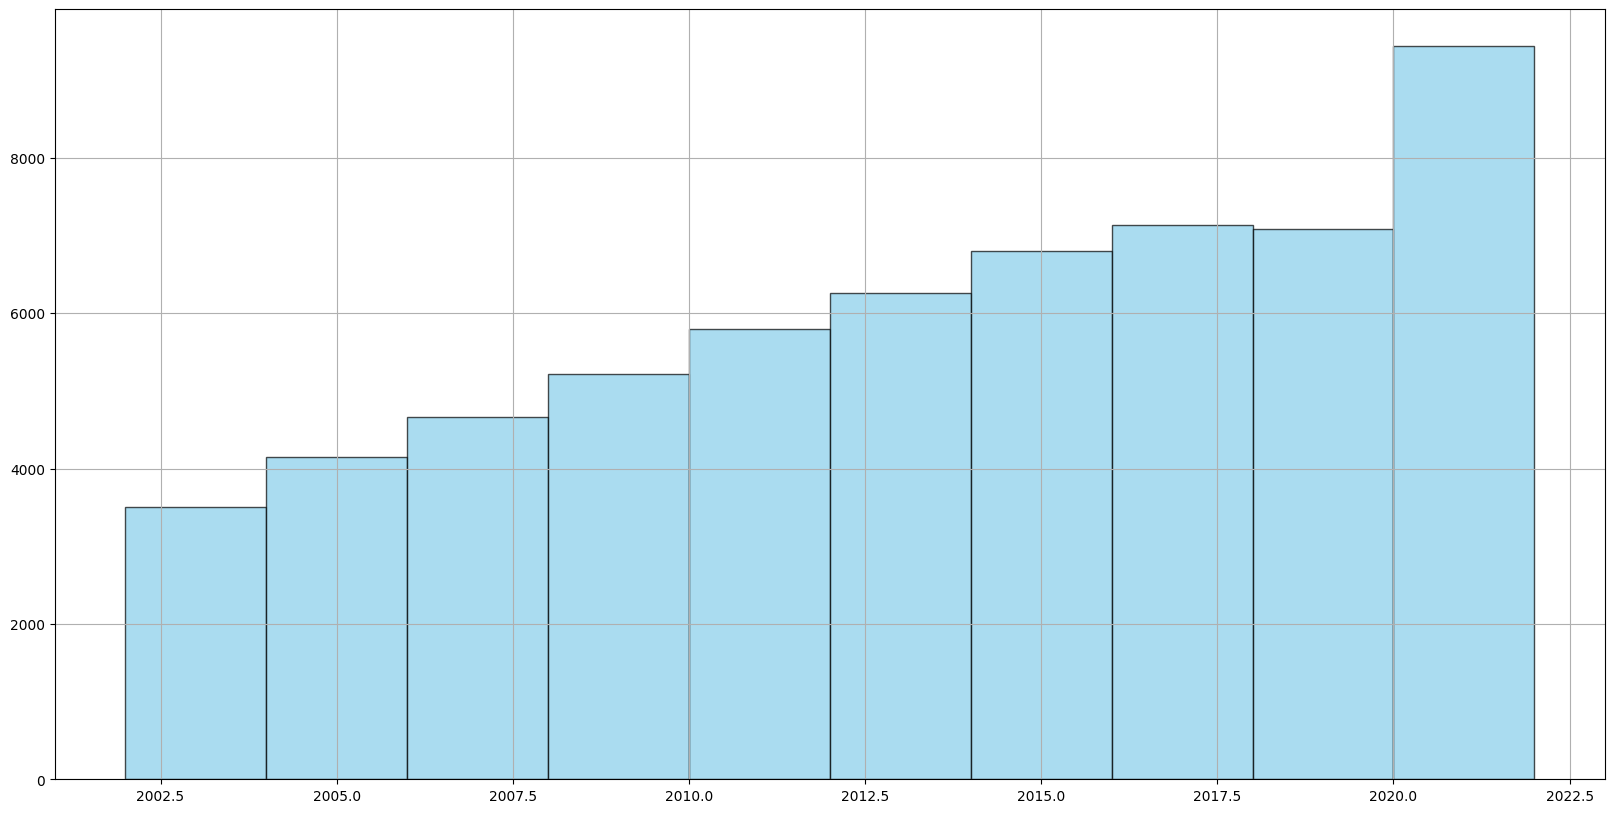

In [17]:
seat_data["Census year"][seat_data["Census year"] < 3000].hist(color='skyblue',
    edgecolor='black',
    alpha=0.7)


In [18]:
some_numbers = pd.Series(range(100))
some_numbers.head()


0    0
1    1
2    2
3    3
4    4
dtype: int64

In [19]:
some_numbers[some_numbers < 8]

0    0
1    1
2    2
3    3
4    4
5    5
6    6
7    7
dtype: int64

In [20]:
some_numbers[(some_numbers < 4) | (some_numbers >= 97)]


0      0
1      1
2      2
3      3
97    97
98    98
99    99
dtype: int64

Distribution of restaurants or cafes with less than 300 seats

Text(0.5, 1.0, 'Distribution of restaurants & cafes with less than 300')

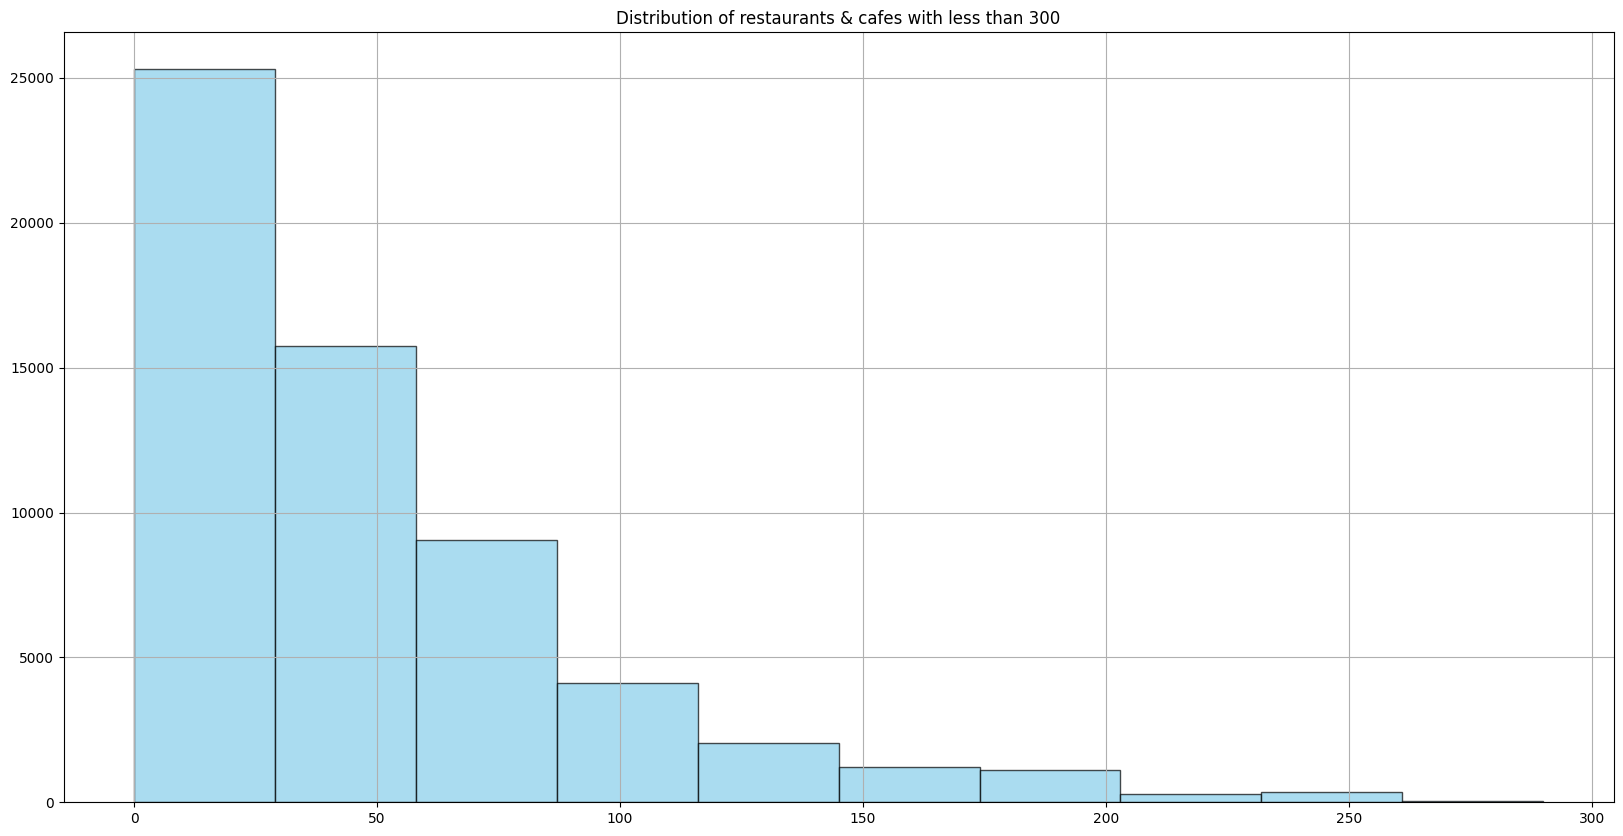

In [21]:
upper_bound = 300
seat_data["Number of seats"][seat_data["Number of seats"] < upper_bound].hist(color='skyblue',
    edgecolor='black',
    alpha=0.7)
plt.title(f"Distribution of restaurants & cafes with less than {upper_bound}")


In [22]:
from shapely.geometry import Point

a = burbs.iloc[0]

csv_latitude = seat_data.iloc[0]['Latitude']
csv_longitude = seat_data.iloc[0]['Longitude']
point = Point(csv_longitude, csv_latitude)

is_within = point.within(a.geometry)
print(is_within)

True


Text(0.5, 1.0, 'Amount of cafes & restaurants under 2023')

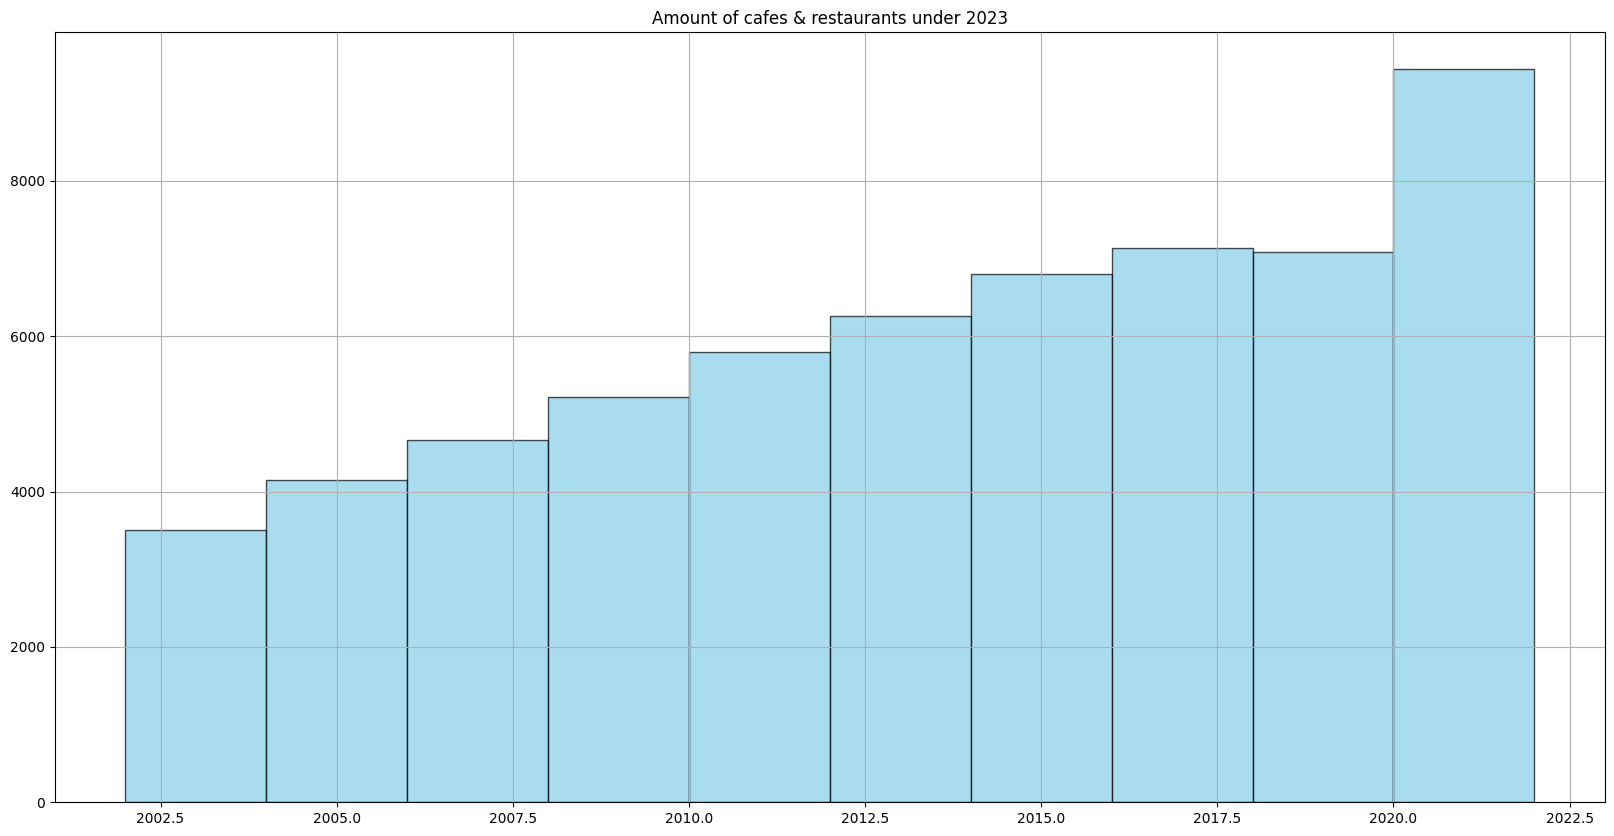

In [23]:
upper_bound = 2023
seat_data["Census year"][seat_data["Census year"] < upper_bound].hist(color='skyblue',
    edgecolor='black',
    alpha=0.7)
plt.title(f"Amount of cafes & restaurants under {upper_bound}")

In [24]:
seat_data.head(2)

,Census year,Block ID,Property ID,Base property ID,Building address,CLUE small area,Trading name,Business address,Industry (ANZSIC4) code,Industry (ANZSIC4) description,Seating type,Number of seats,Longitude,Latitude,location,geometry
0,2017,6,578324,573333,2 Swanston Street MELBOURNE 3000,Melbourne (CBD),Transport Hotel,"Tenancy 29, Ground , 2 Swanston Street MELBOUR...",4520,"Pubs, Taverns and Bars",Seats - Indoor,230,144.969942,-37.817778,"-37.817777826050005, 144.96994164279243",POINT (144.96994164279243 -37.817777826050005)
1,2017,6,578324,573333,2 Swanston Street MELBOURNE 3000,Melbourne (CBD),Transport Hotel,"Tenancy 29, Ground , 2 Swanston Street MELBOUR...",4520,"Pubs, Taverns and Bars",Seats - Outdoor,120,144.969942,-37.817778,"-37.817777826050005, 144.96994164279243",POINT (144.96994164279243 -37.817777826050005)


In [25]:
seat_data["Industry (ANZSIC4) description"].value_counts()

Industry (ANZSIC4) description
Cafes and Restaurants                              44982
Takeaway Food Services                              8164
Pubs, Taverns and Bars                              3716
Accommodation                                       1129
Other Specialised Food Retailing                     269
                                                   ...  
Other Auxiliary Finance and Investment Services        2
Architectural Services                                 2
Business and Professional Association Services         2
Management Advice and Other Consulting Services        2
Computer System Design and Related Services            1
Name: count, Length: 71, dtype: int64

<Axes: xlabel='Industry (ANZSIC4) description'>

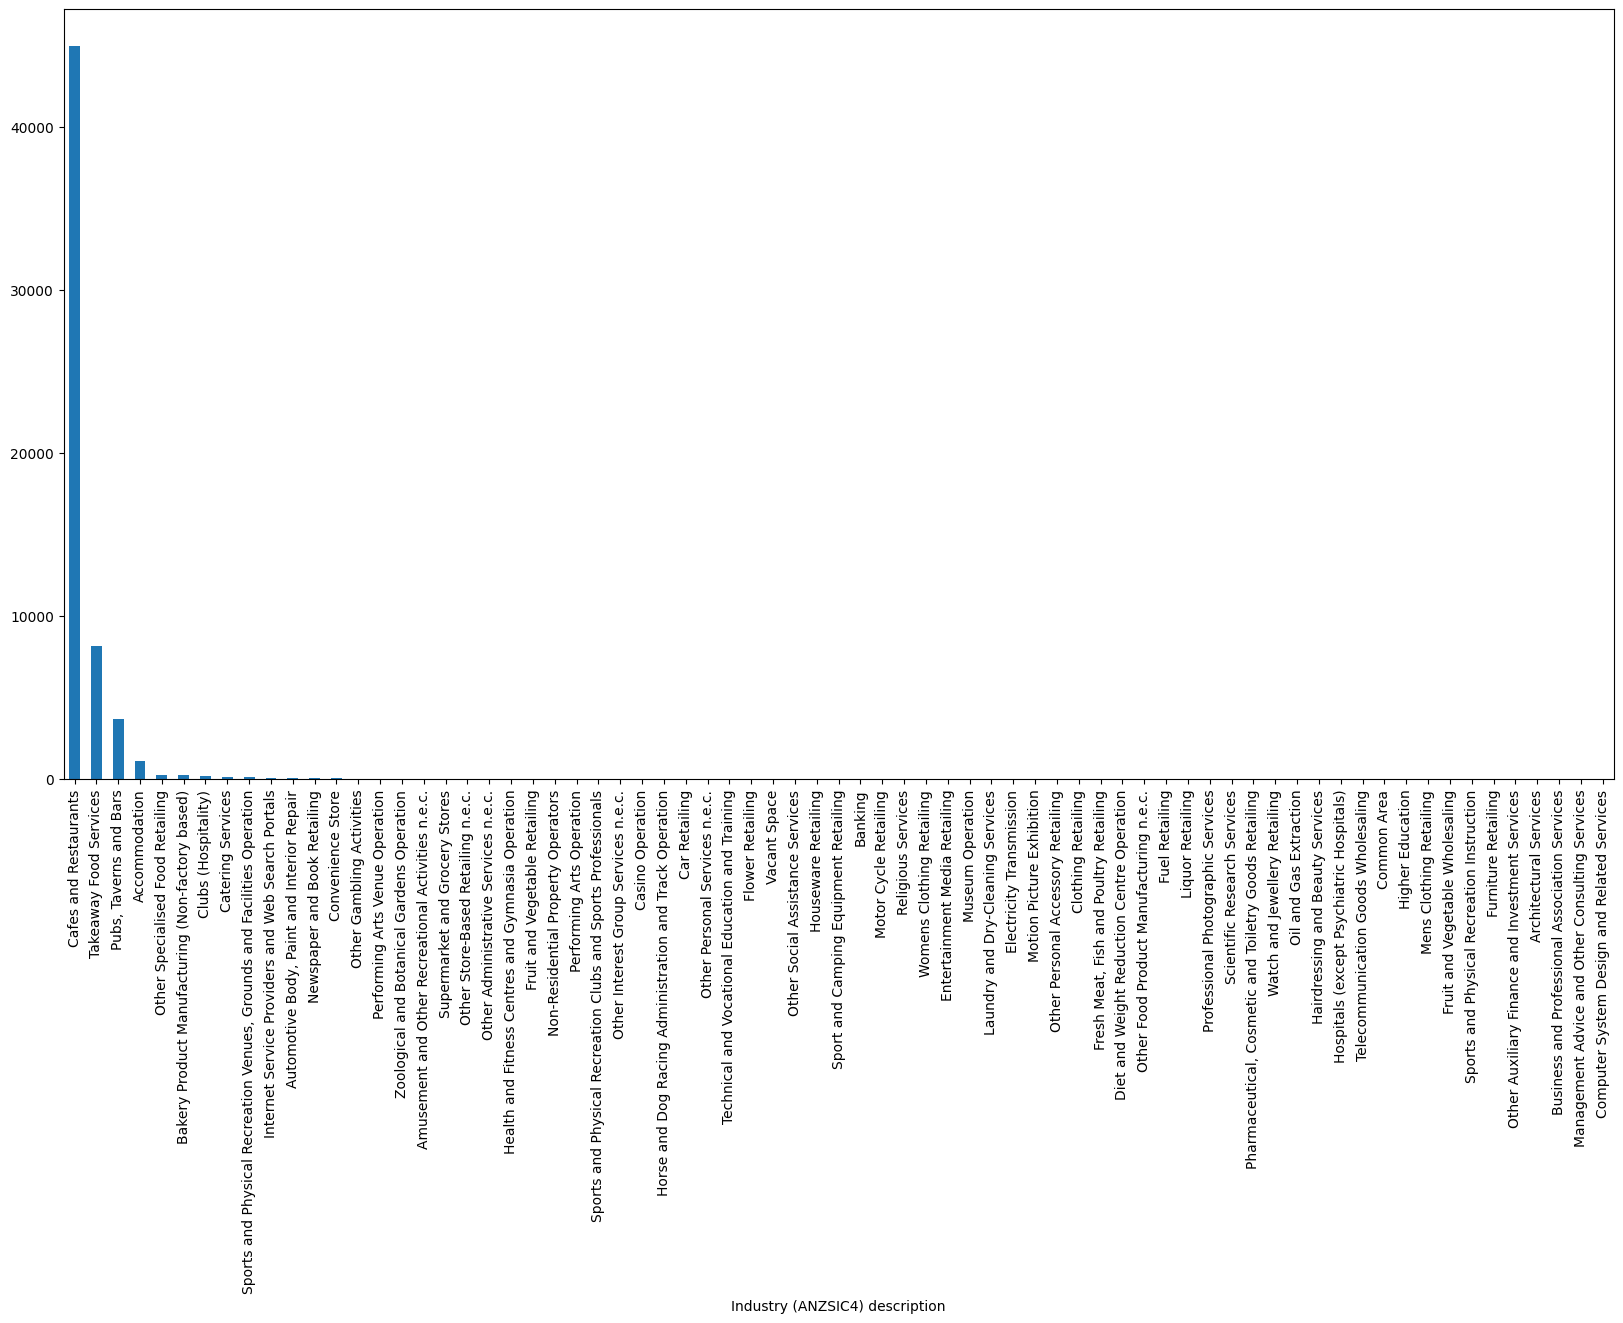

In [26]:
seat_data["Industry (ANZSIC4) description"].value_counts().plot(kind="bar")

Distribution of indoor and outdoor seating

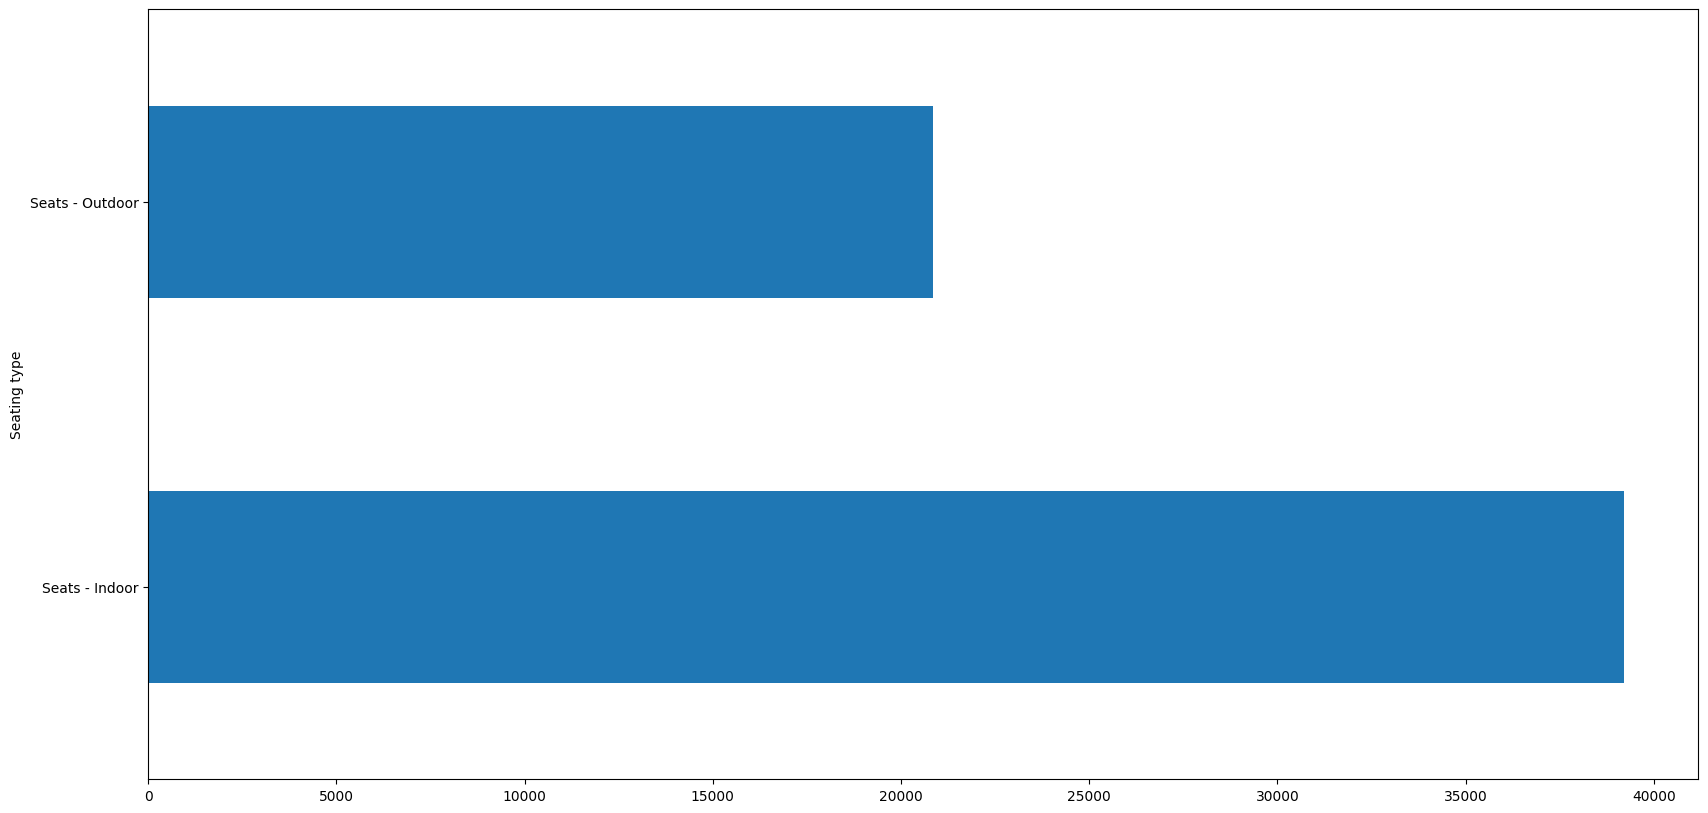

In [27]:
seating_type_counts = seat_data['Seating type'].value_counts()
seating_type_counts.plot(kind="barh");


Distribution of restaurants & cafes with less than 120 seats

<Axes: >

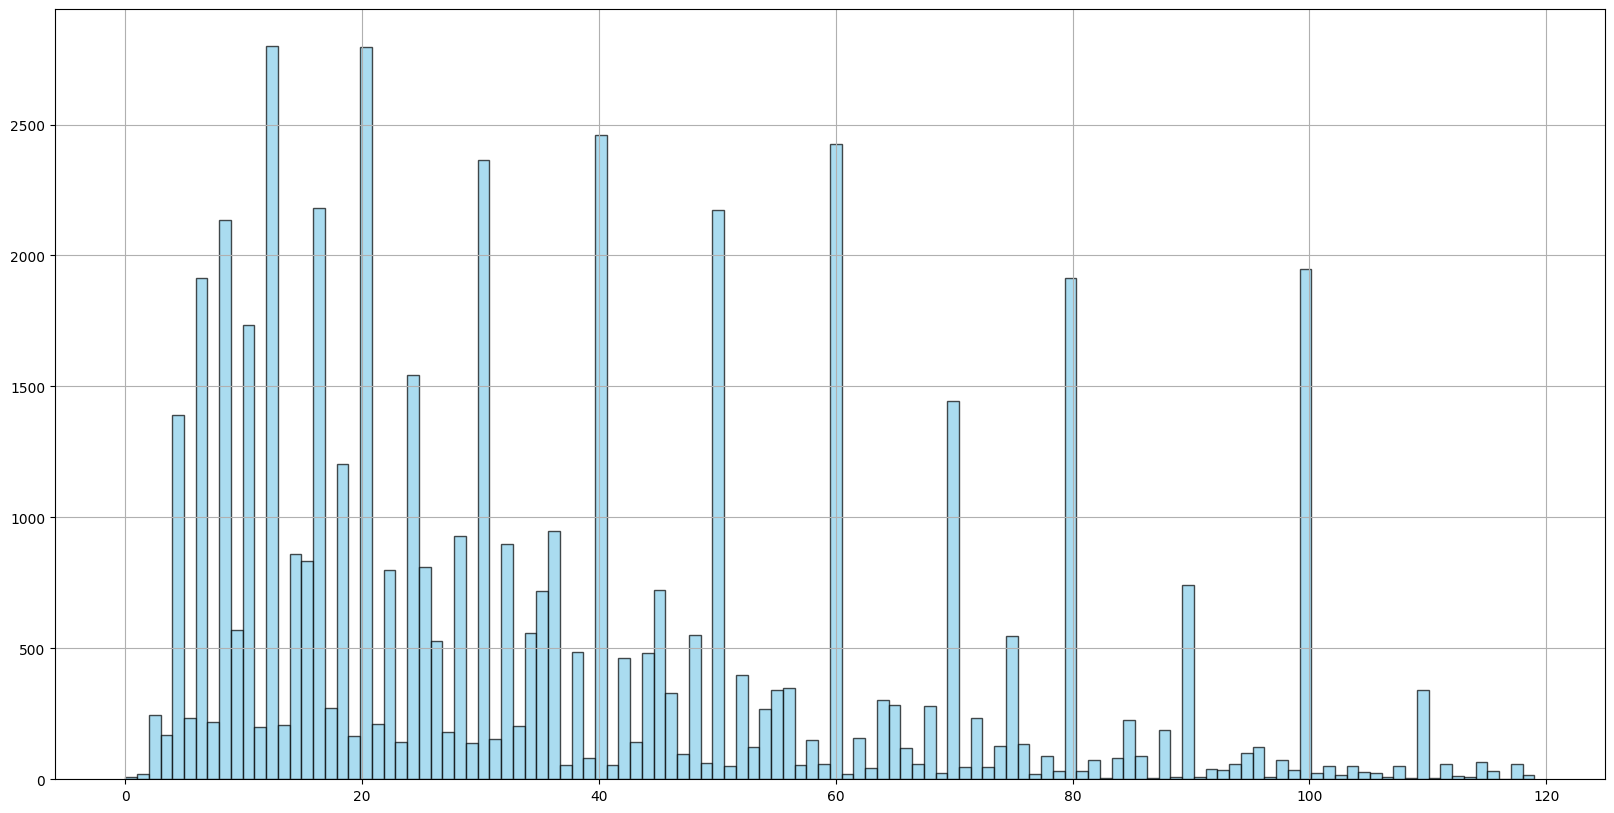

In [28]:
sd = seat_data["Number of seats"]
sd[sd<120].hist(bins=120, color='skyblue',
    edgecolor='black',
    alpha=0.7)

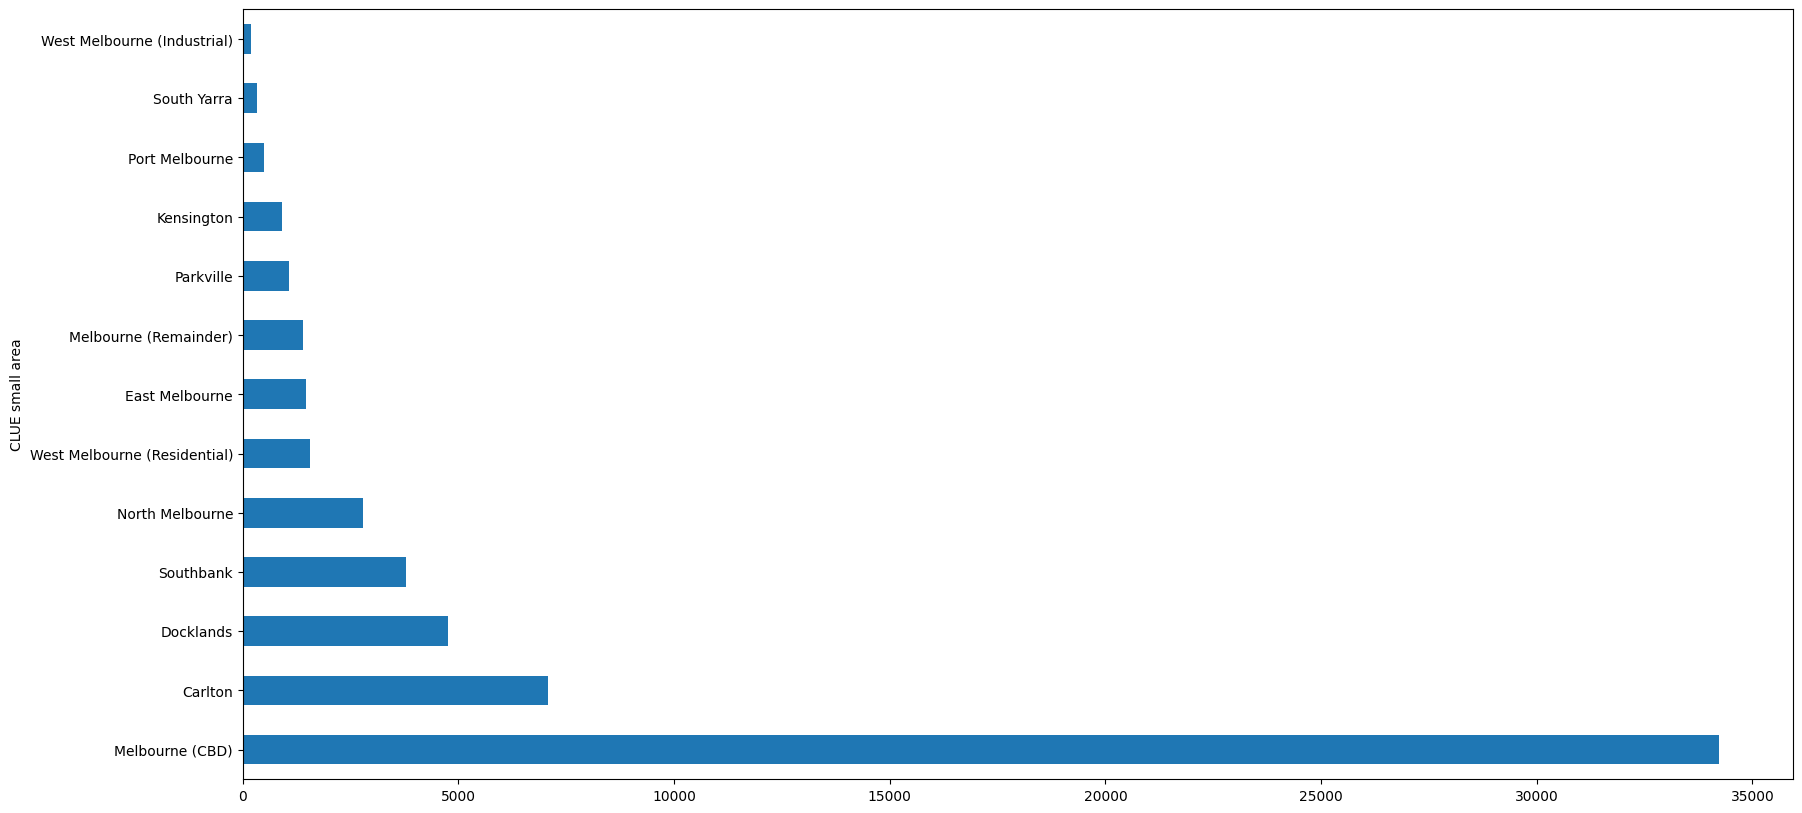

In [29]:
CLUE_small_area_counts = seat_data['CLUE small area'].value_counts()
CLUE_small_area_counts.plot(kind="barh");

Distribution of the total number of industry types counted

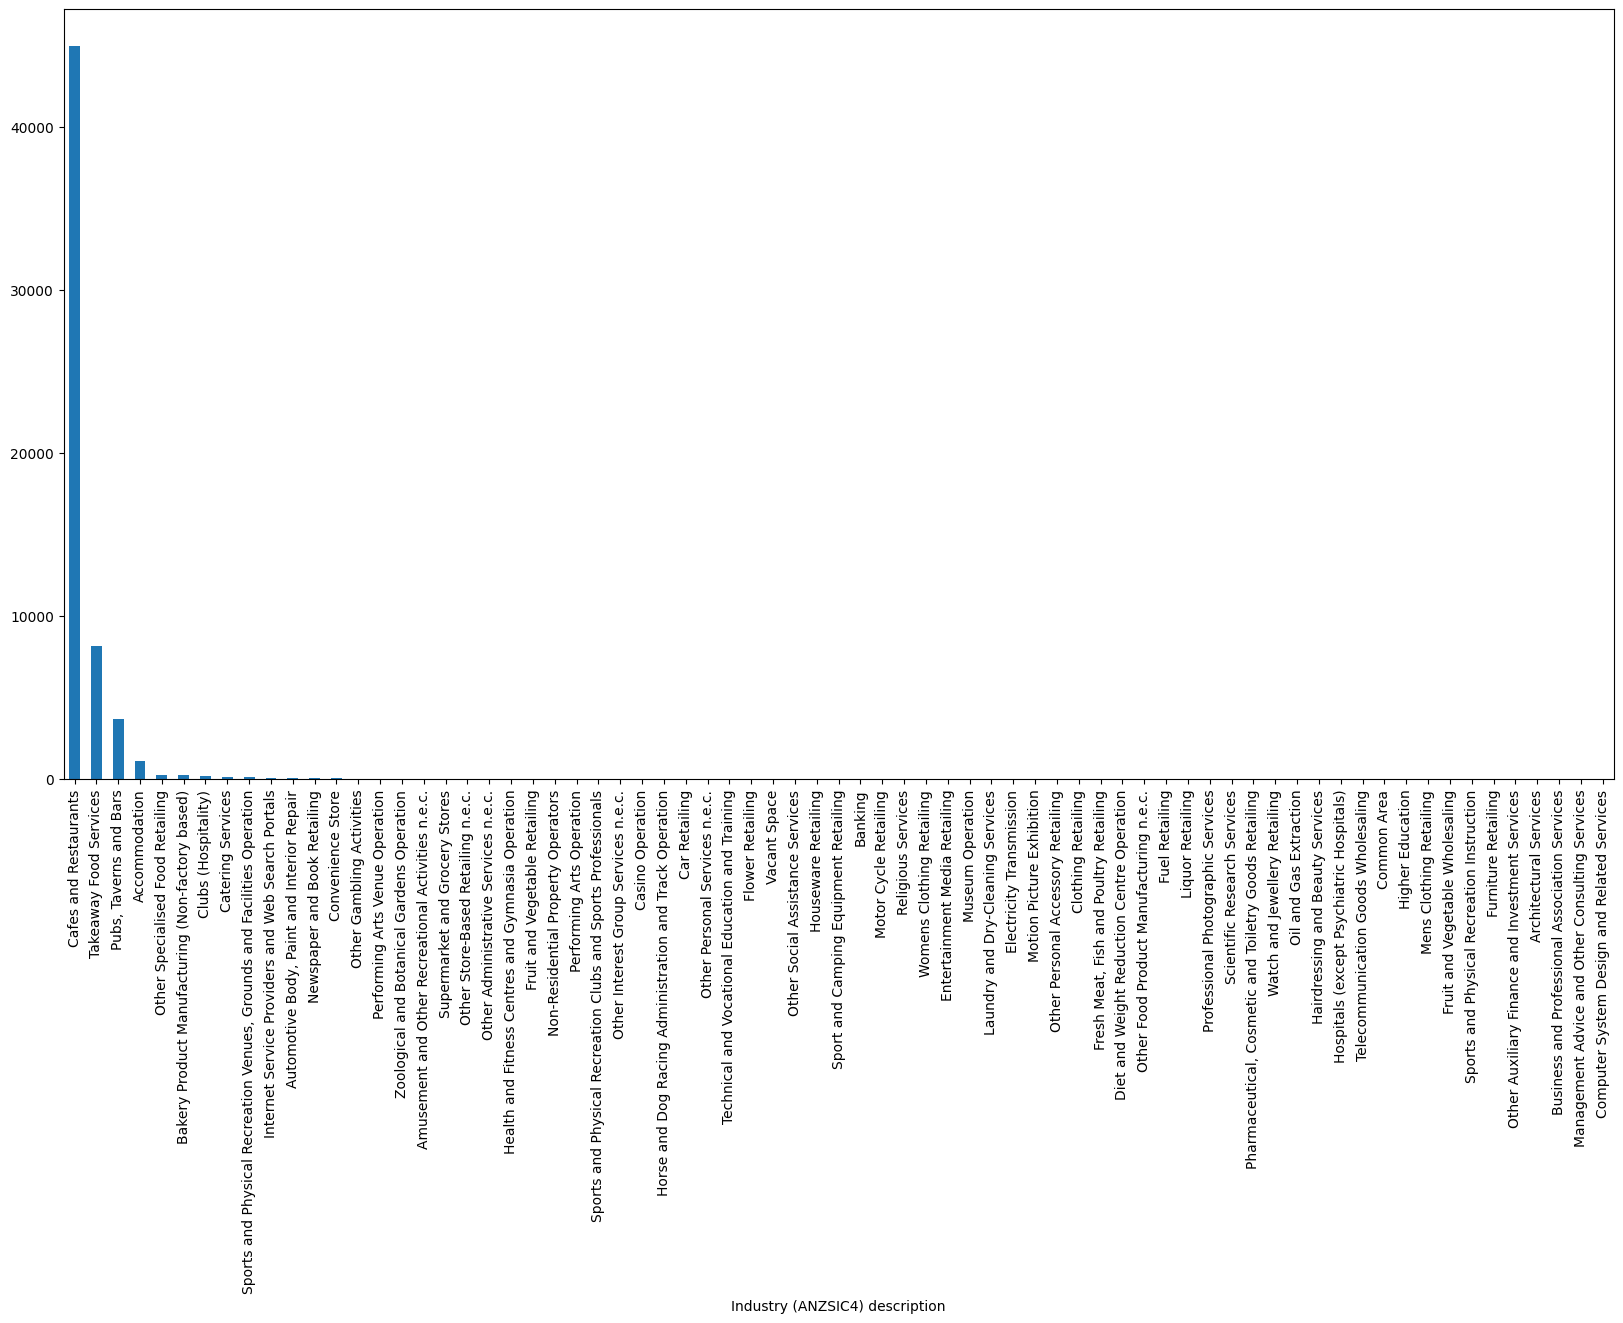

In [30]:
Industry_types_counts = seat_data['Industry (ANZSIC4) description'].value_counts()
Industry_types_counts.plot(kind="bar");

Distribution of industry types that were counted less than 100 times

<Axes: xlabel='Industry (ANZSIC4) description'>

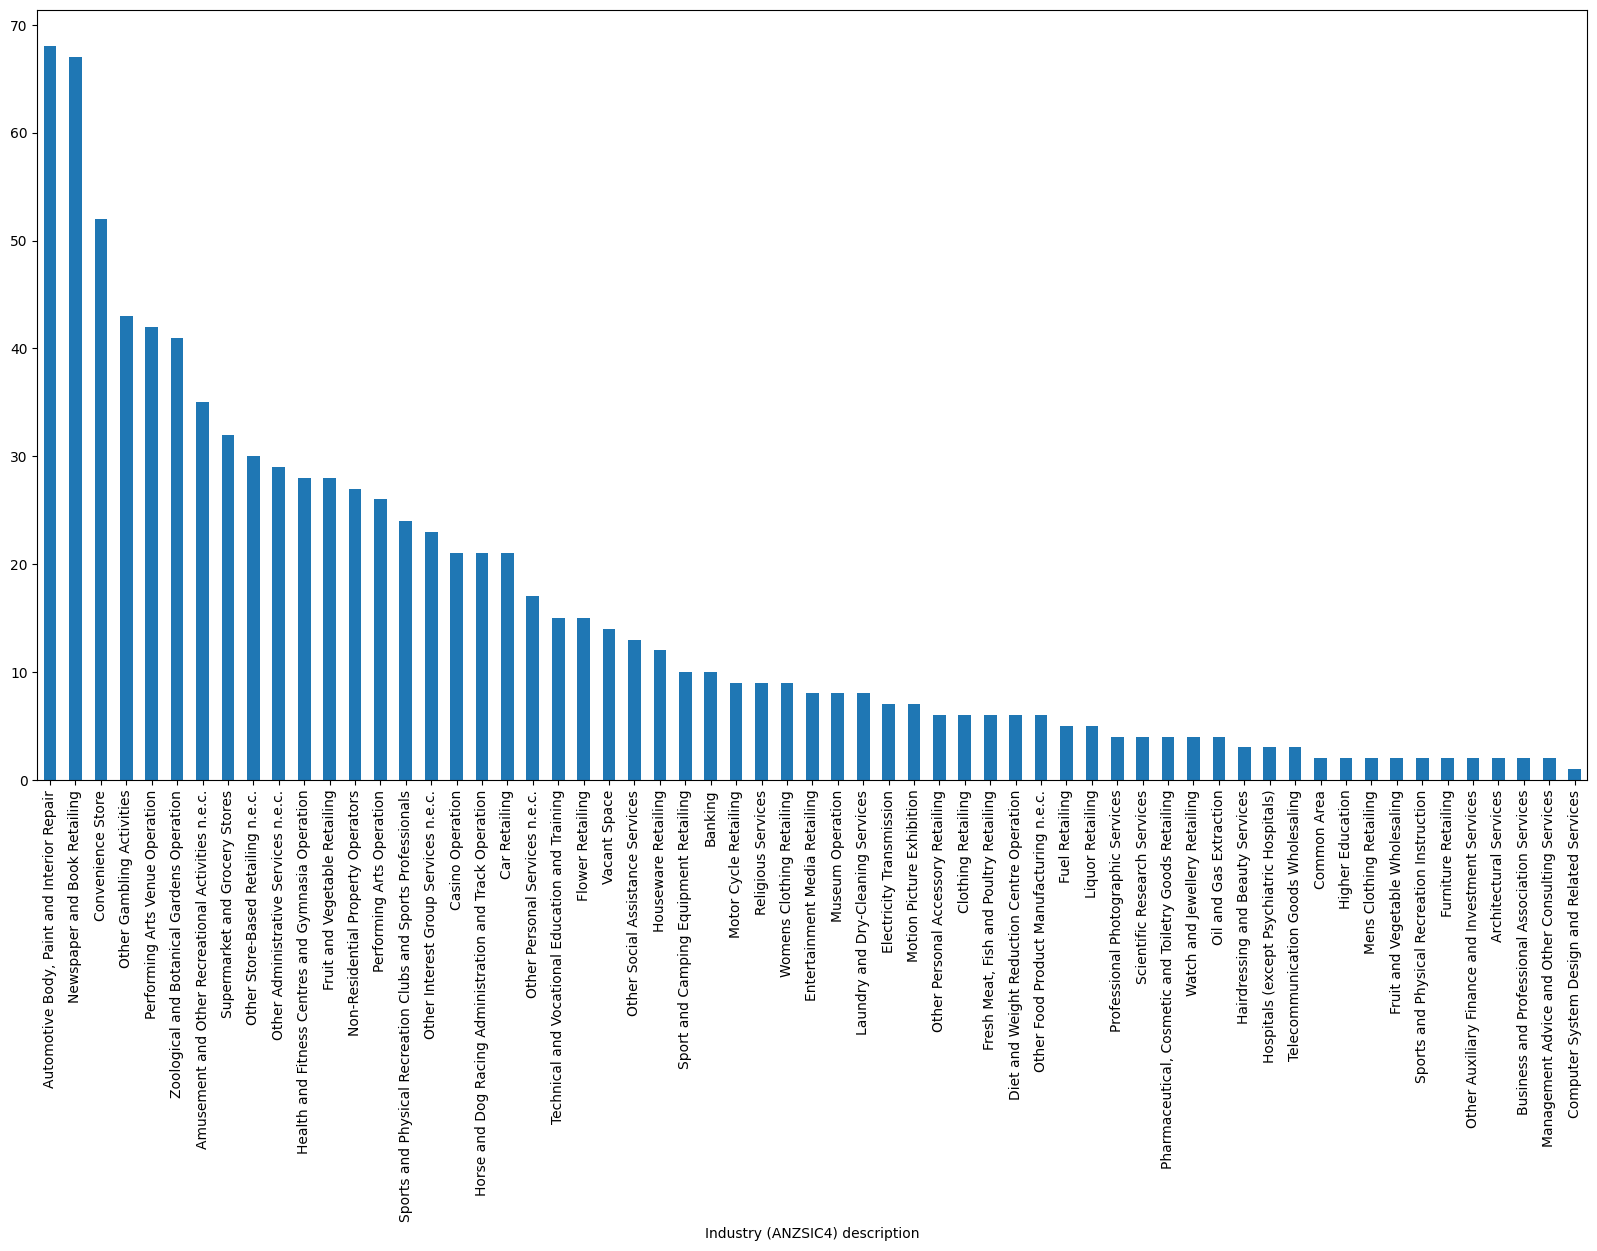

In [31]:
Industry_types_counts[Industry_types_counts < 100].plot(kind="bar")

<Axes: ylabel='Industry (ANZSIC4) description'>

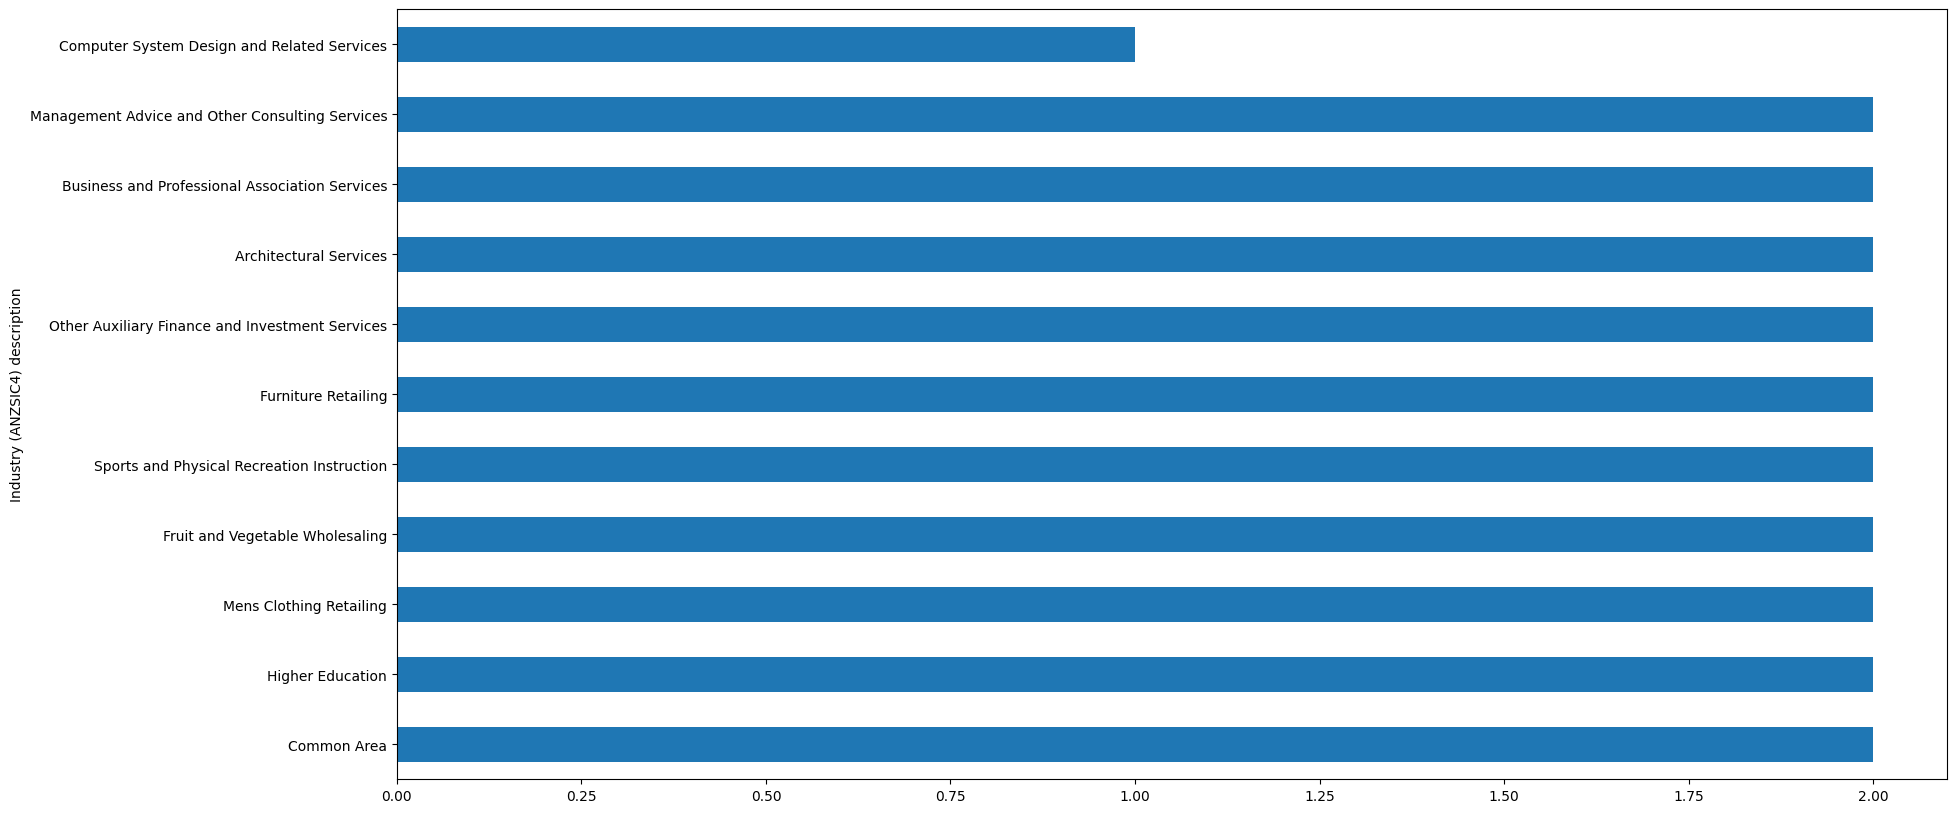

In [32]:
pdvc = Industry_types_counts[Industry_types_counts < 100]

pdvc[pdvc < 3].plot(kind="barh")

Distribution of restaurants & cafes with less than 100 seats

<Axes: >

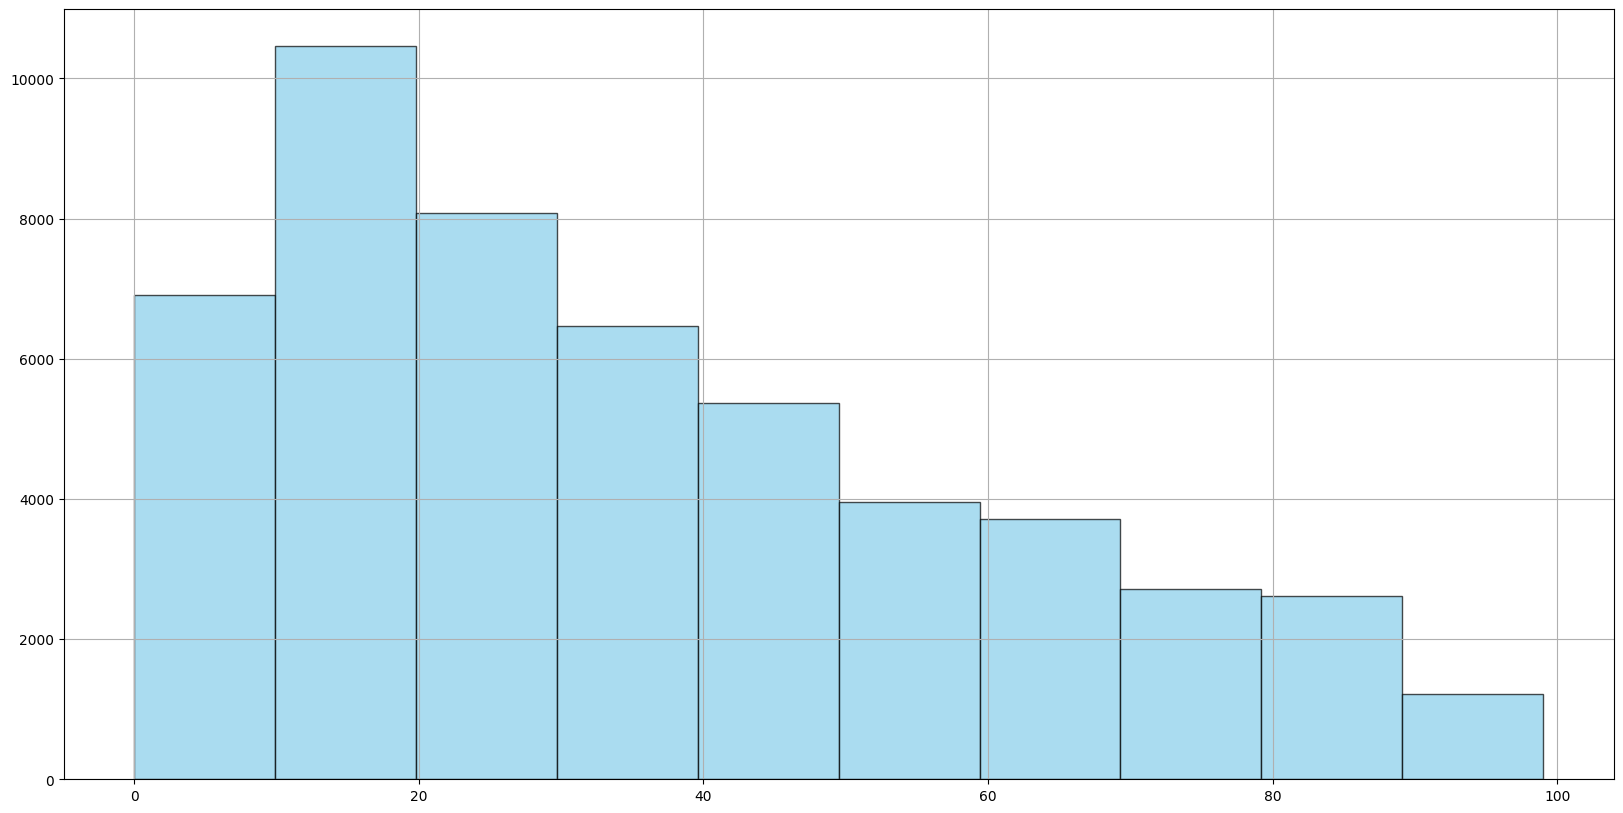

In [35]:
seat_data["Number of seats"][seat_data["Number of seats"] < 100].hist(color='skyblue',
    edgecolor='black',
    alpha=0.7)


Number of Stores with Indoor and Outdoor Seating

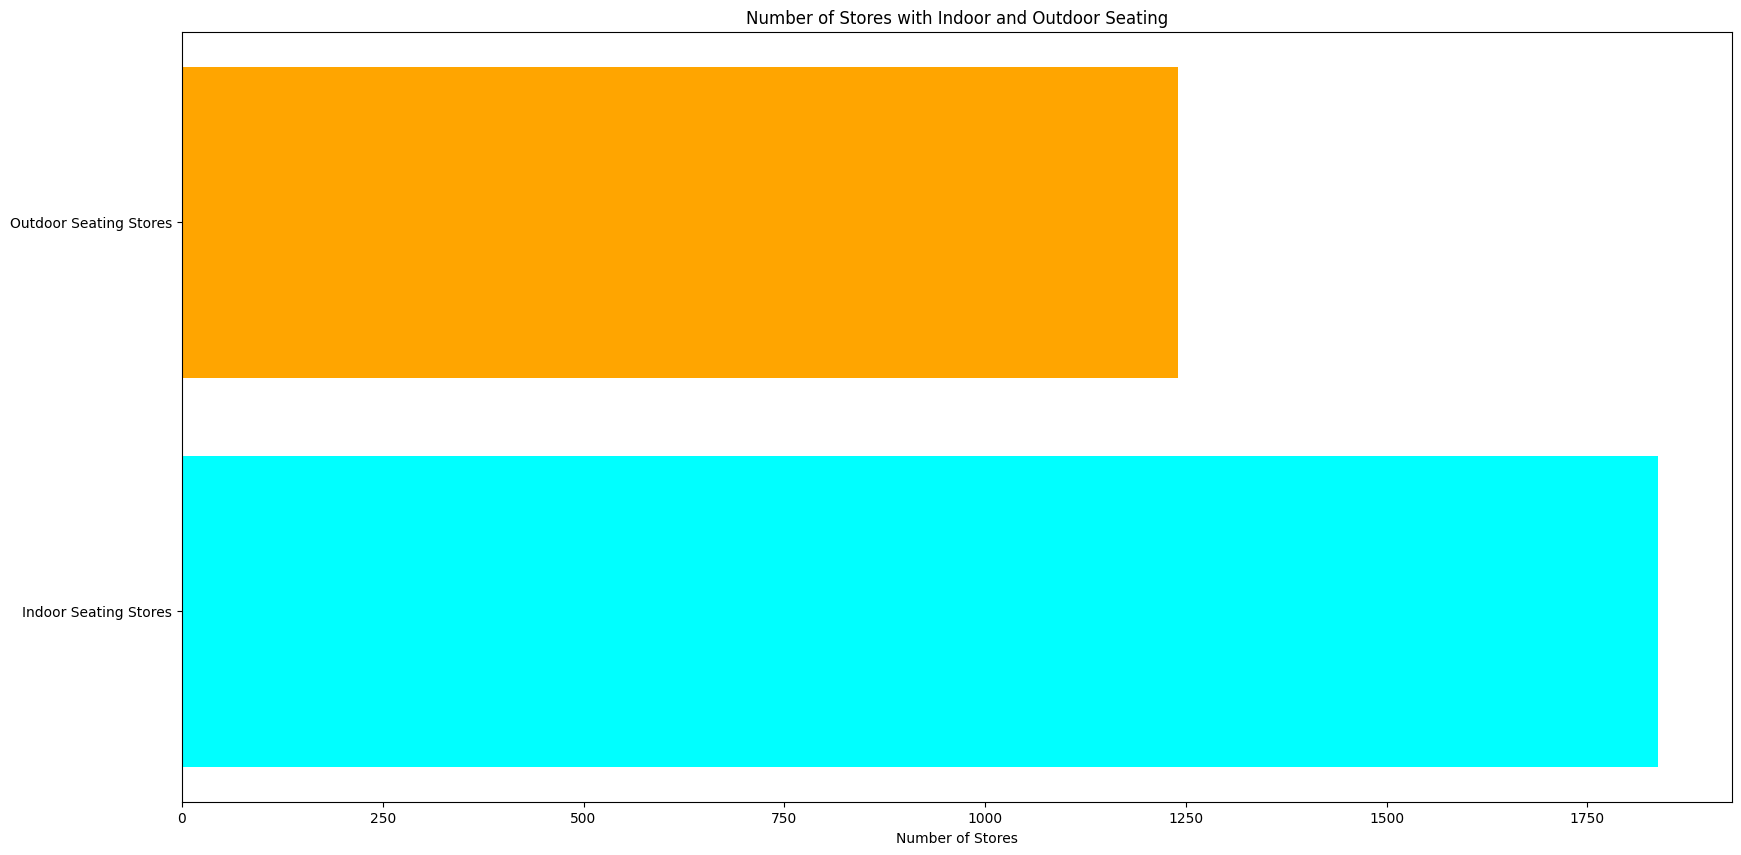

In [36]:
indoor_outdoor_counts = seat_data.groupby('Property ID')['Seating type'].unique()
store_with_indoor = indoor_outdoor_counts.apply(lambda x: 'Seats - Indoor' in x).sum()
store_with_outdoor = indoor_outdoor_counts.apply(lambda x: 'Seats - Outdoor' in x).sum()

seating_counts = {
    'Indoor Seating Stores': store_with_indoor,
    'Outdoor Seating Stores': store_with_outdoor
}
plt.barh(list(seating_counts.keys()), list(seating_counts.values()), color=['aqua', 'orange'])
plt.xlabel('Number of Stores')
plt.title('Number of Stores with Indoor and Outdoor Seating')
plt.show()

Average Number of Seats by Seating Type

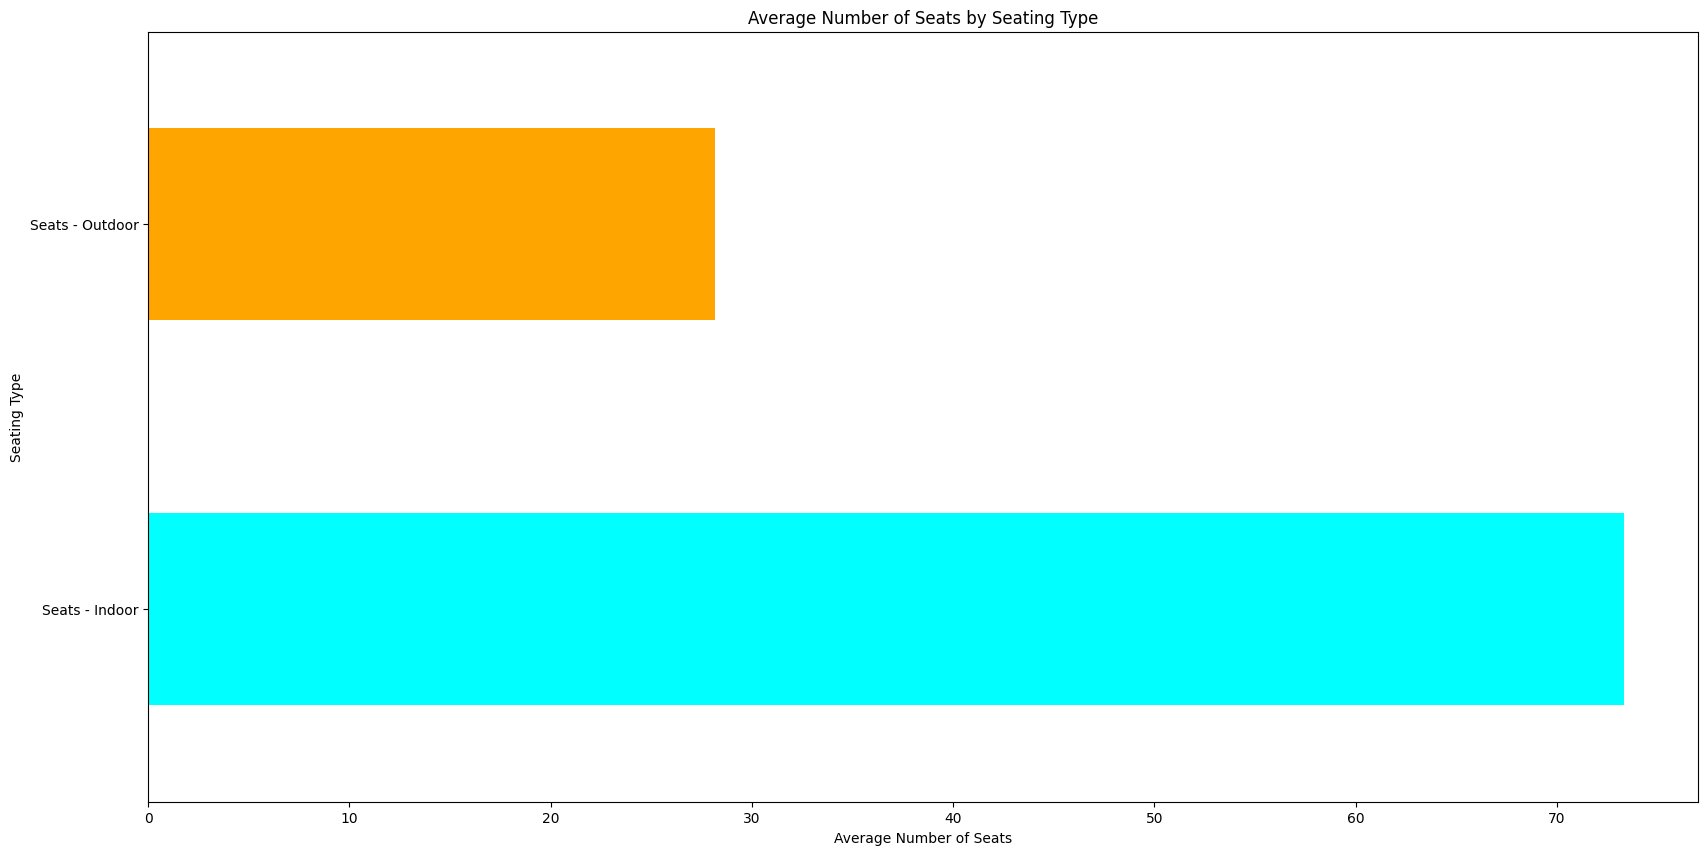

In [37]:
avg_seating_type_seats = seat_data.groupby('Seating type')['Number of seats'].mean()

seating_summary = pd.DataFrame({
    'Count': seating_type_counts,
    'Average Seats': avg_seating_type_seats
})

avg_seating_type_seats.plot(kind='barh', color=['aqua', 'orange'])
plt.title('Average Number of Seats by Seating Type')
plt.xlabel('Average Number of Seats')
plt.ylabel('Seating Type')
plt.show()


Total number of indoor and outdoor seats per year

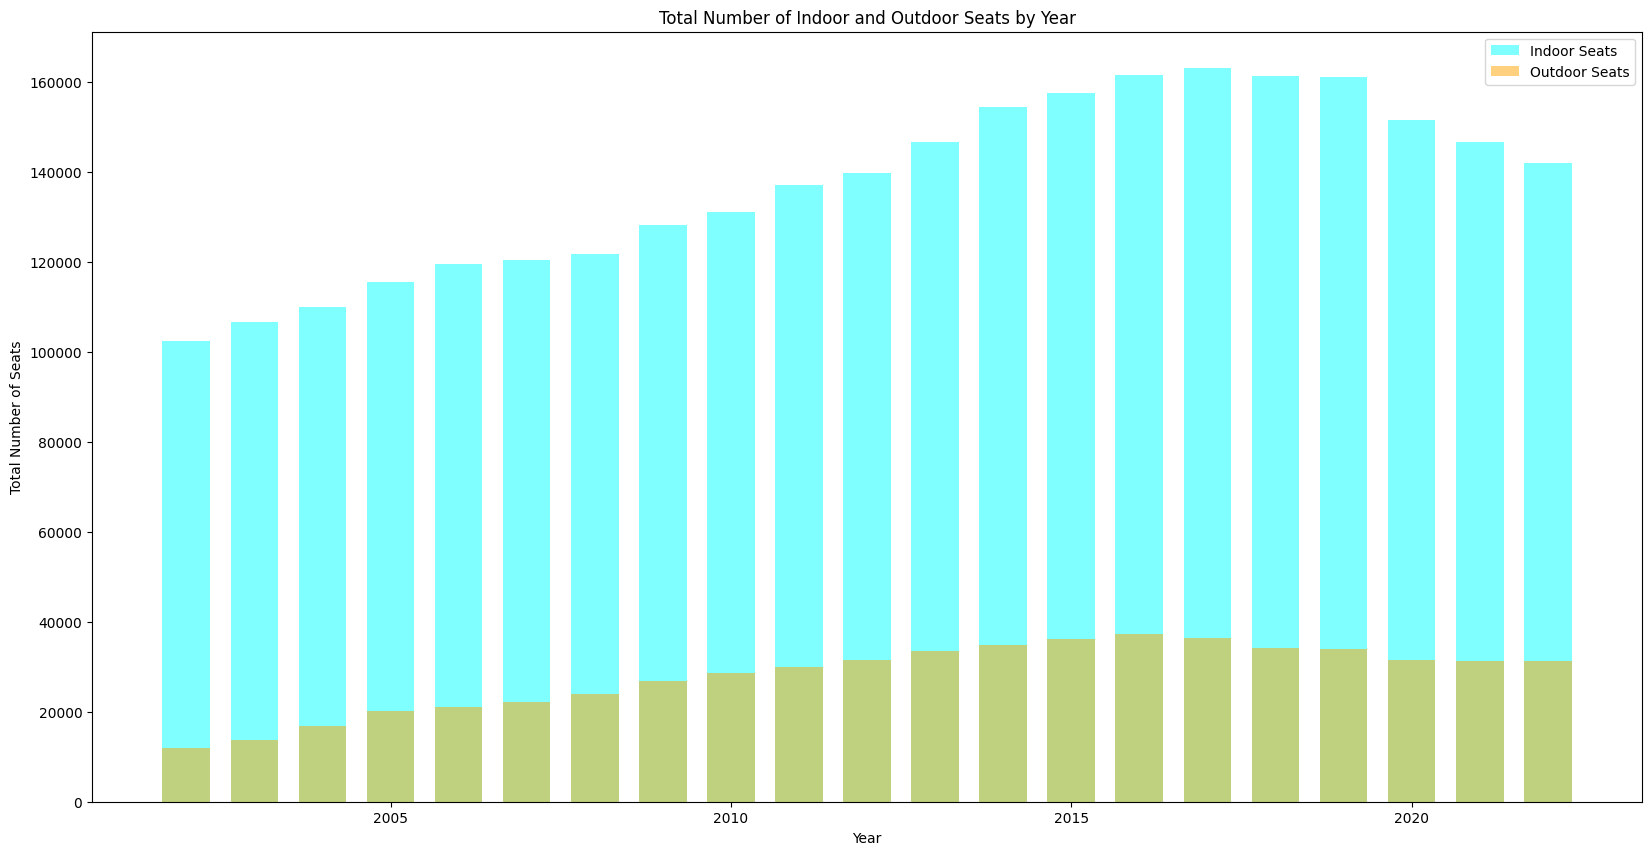

In [38]:
indoor_seats_per_year = seat_data[seat_data['Seating type'] == 'Seats - Indoor'].groupby('Census year')['Number of seats'].sum()

outdoor_seats_per_year = seat_data[seat_data['Seating type'] == 'Seats - Outdoor'].groupby('Census year')['Number of seats'].sum()

plt.bar(indoor_seats_per_year.index, indoor_seats_per_year, width=0.7, color='aqua', alpha=0.5, label='Indoor Seats')
plt.bar(outdoor_seats_per_year.index, outdoor_seats_per_year, width=0.7, color='orange', alpha=0.5, label='Outdoor Seats')

plt.title('Total Number of Indoor and Outdoor Seats by Year')
plt.xlabel('Year')
plt.ylabel('Total Number of Seats')

plt.legend()

plt.show()

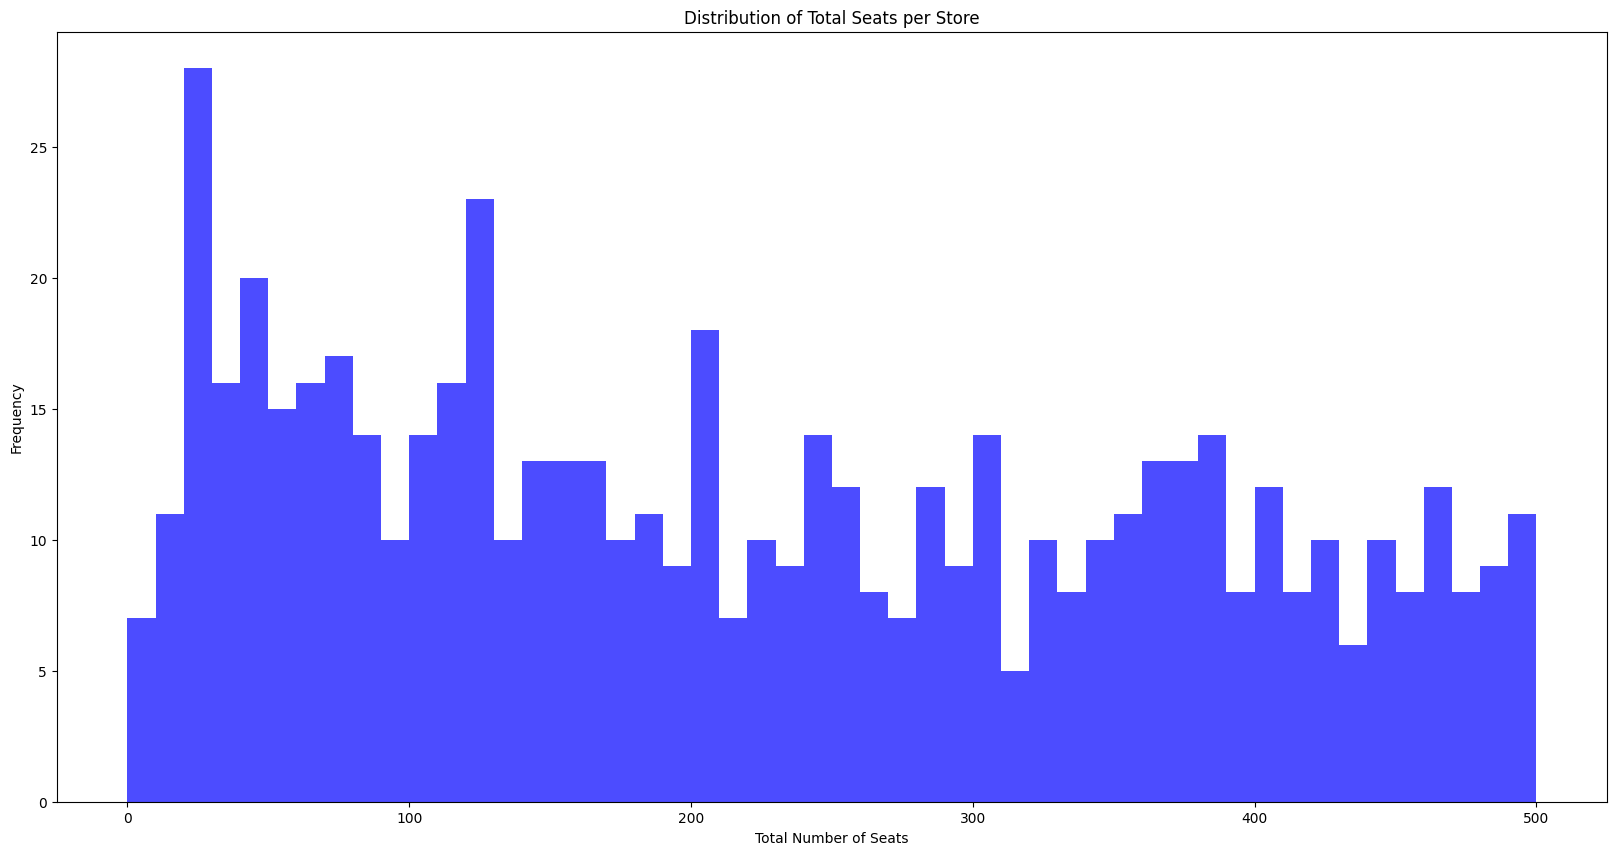

In [39]:
total_seats_per_store = seat_data.groupby('Property ID')['Number of seats'].sum()

plt.hist(total_seats_per_store, bins=50, range=(0, 500), facecolor="blue", alpha=0.7)

plt.title('Distribution of Total Seats per Store')
plt.xlabel('Total Number of Seats')
plt.ylabel('Frequency')

plt.show()

We can nice that up a bit by pulling the parameters out as variables:
(unmagically, no difference!)

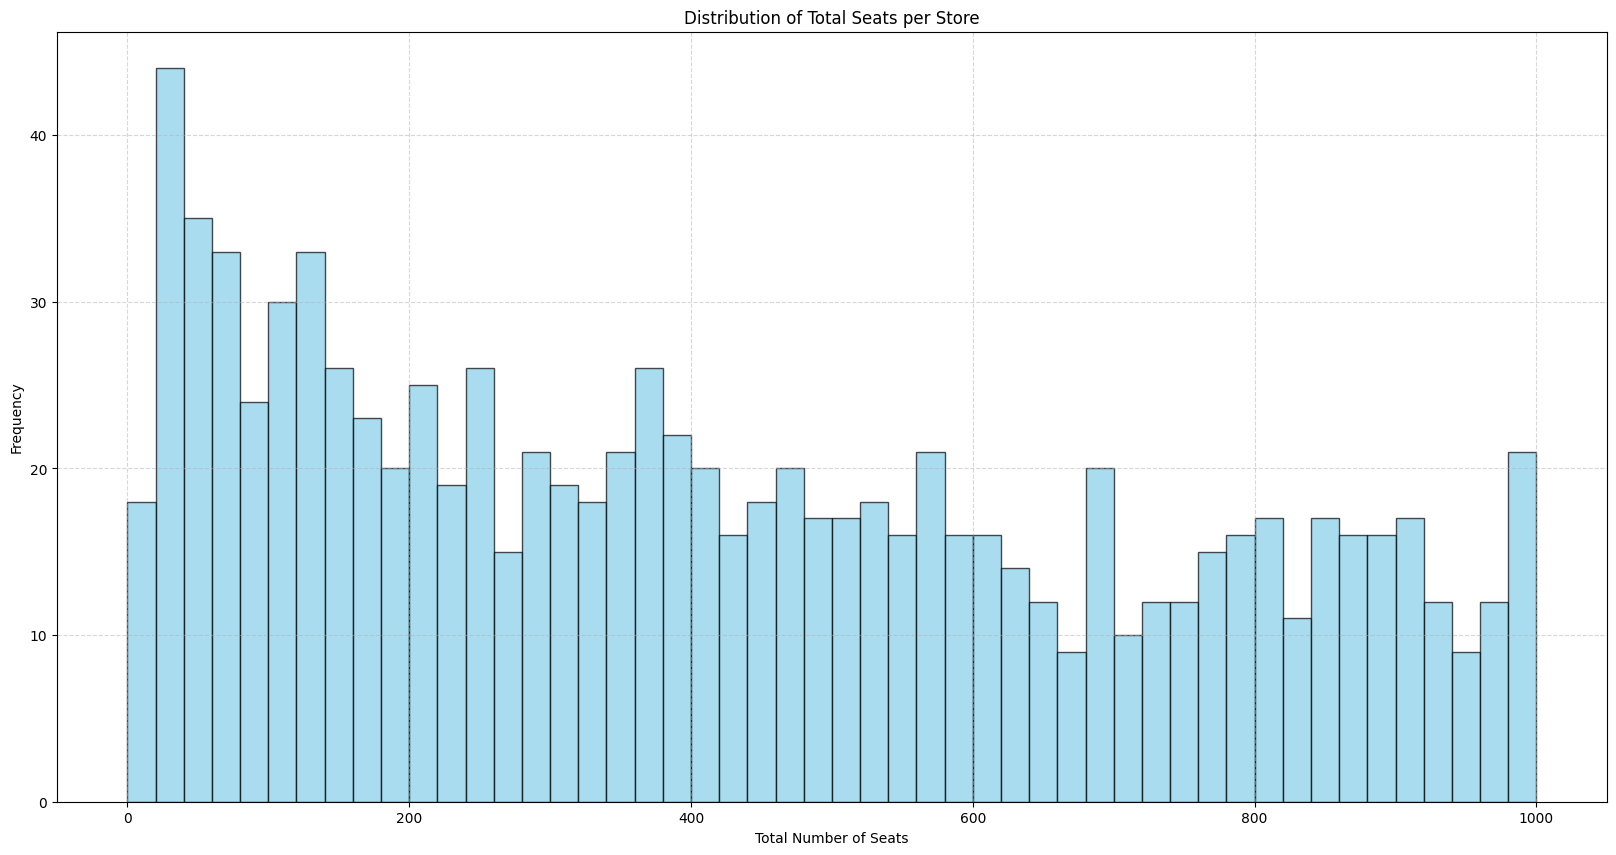

In [40]:
number_of_bins = 50
lower_bound = 0
upper_bound = 1000

plt.hist(
    total_seats_per_store,
    bins=number_of_bins,
    range=(lower_bound, upper_bound),
    color='skyblue',
    edgecolor='black',
    alpha=0.7
)

plt.grid(True, linestyle='--', alpha=0.5)

plt.title('Distribution of Total Seats per Store')
plt.xlabel('Total Number of Seats')
plt.ylabel('Frequency')

plt.show()


Distribution of Average Number of Seats per Industry

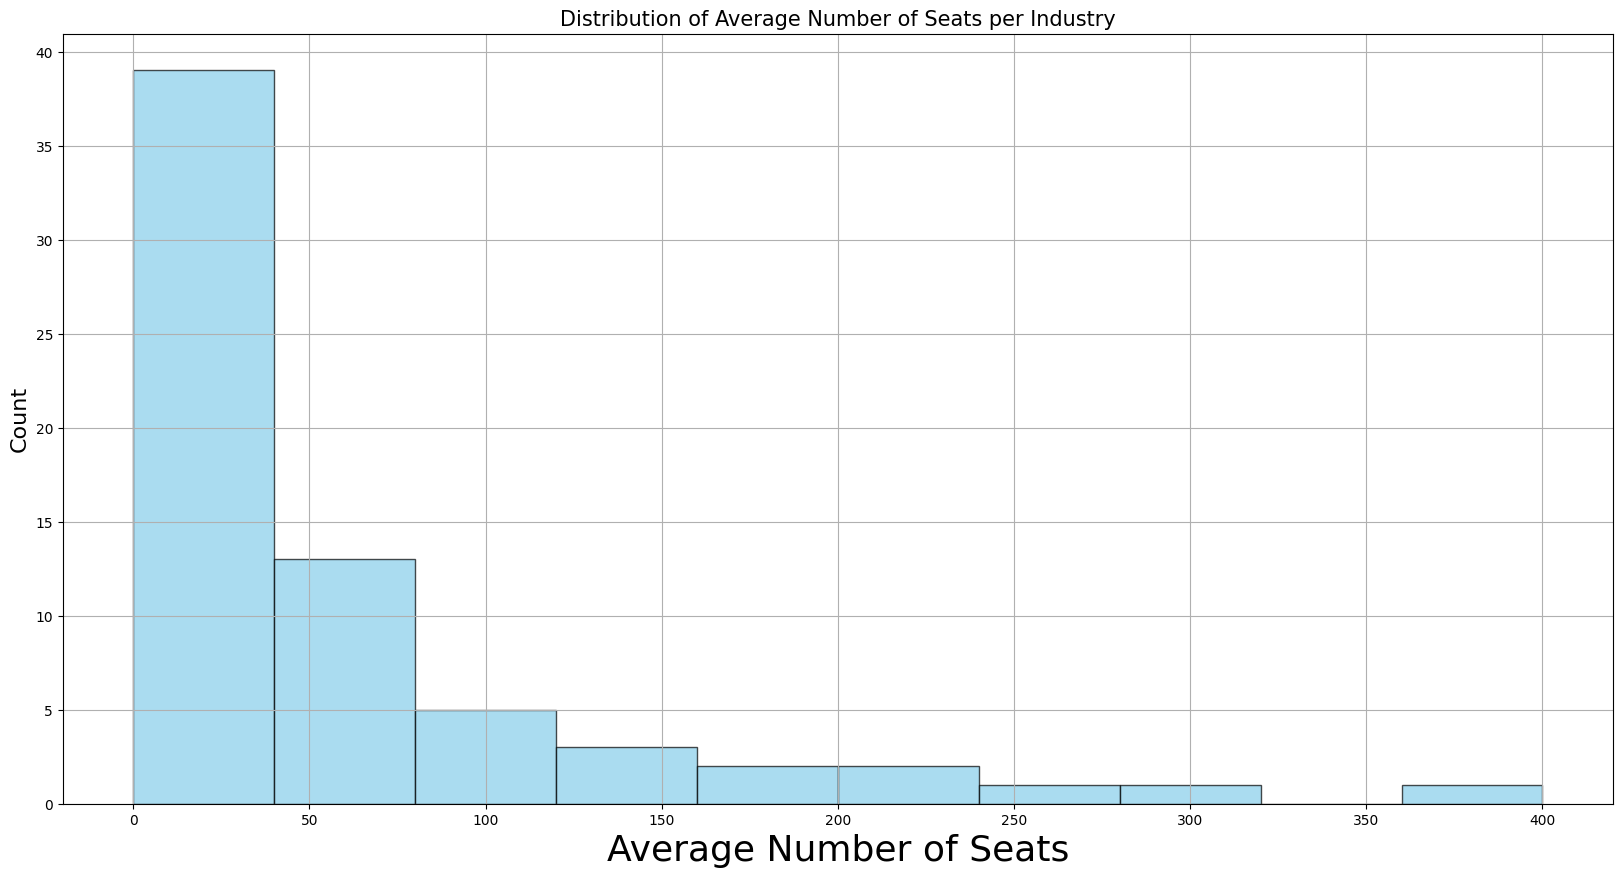

In [41]:
industry_seat_counts = seat_data.groupby('Industry (ANZSIC4) description')['Number of seats'].mean()

number_of_bins = 10
lower_bound = 0
upper_bound = 400

plt.hist(industry_seat_counts, bins=number_of_bins, range=(lower_bound, upper_bound), color='skyblue',
    edgecolor='black',
    alpha=0.7)
plt.title("Distribution of Average Number of Seats per Industry", fontsize=15)
plt.xlabel("Average Number of Seats", fontsize=26)
plt.ylabel("Count", fontsize=16)
plt.grid(True)
plt.show()

In [42]:
data = pd.read_csv('cafes-and-restaurants-with-seating-capacity.csv')

data.head(2)

yearly_seats = data.groupby('Census year')['Number of seats'].sum()

print(yearly_seats)


Census year
2002    114191
2003    120153
2004    126818
2005    135682
2006    140553
2007    142513
2008    145637
2009    155007
2010    159667
2011    166952
2012    171129
2013    180109
2014    189346
2015    193714
2016    198747
2017    199222
2018    195256
2019    194972
2020    182994
2021    177932
2022    173221
Name: Number of seats, dtype: int64


In [43]:
first_year = data['Census year'].min()
last_year = data['Census year'].max()
f"range is: {first_year} to {last_year}"


'range is: 2002 to 2022'

In [44]:
year_format_pattern = "%Y"

earliest_year = first_year
latest_year = last_year
f"range is: {earliest_year} to {latest_year}"

'range is: 2002 to 2022'

Which means that we can put those values into our graph title:

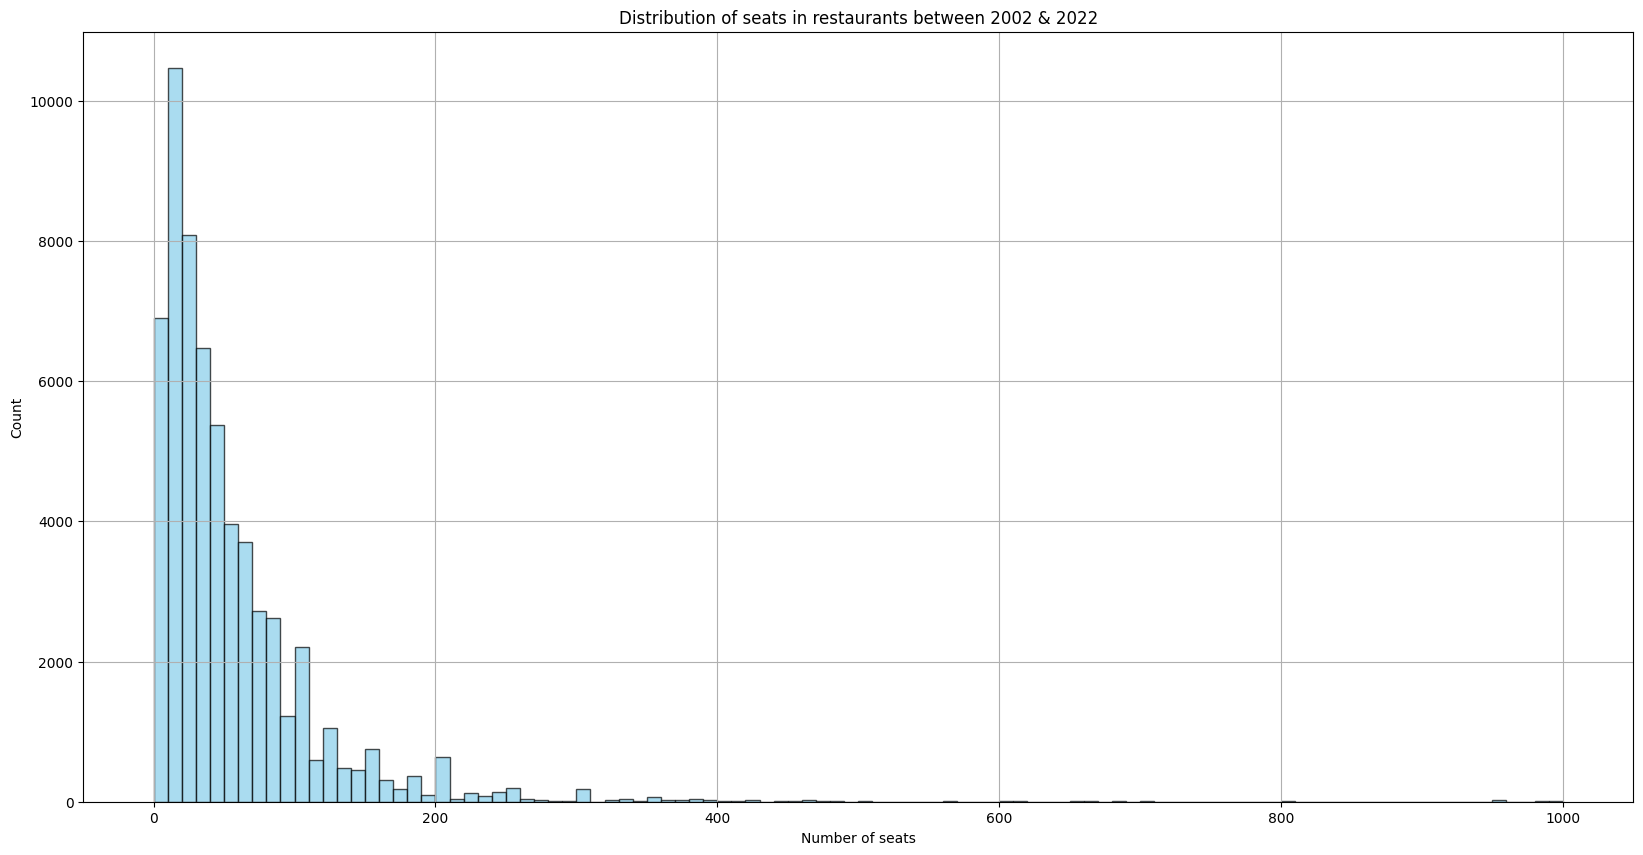

In [45]:
number_of_bins = 100
lower_bound = 0
upper_bound = 1000

plt.hist(
    data["Number of seats"], bins=number_of_bins, range=(lower_bound, upper_bound), color='skyblue', edgecolor='black', alpha=0.7
)

plt.title(
    f"Distribution of seats in restaurants between {first_year} & {last_year}",
    fontsize=12,
)

plt.xlabel("Number of seats", fontsize=10)
plt.ylabel("Count", fontsize=10)

plt.grid(True)

plt.show()


Line chart showing the changing trend of the total number of seats in restaurants each year

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd S

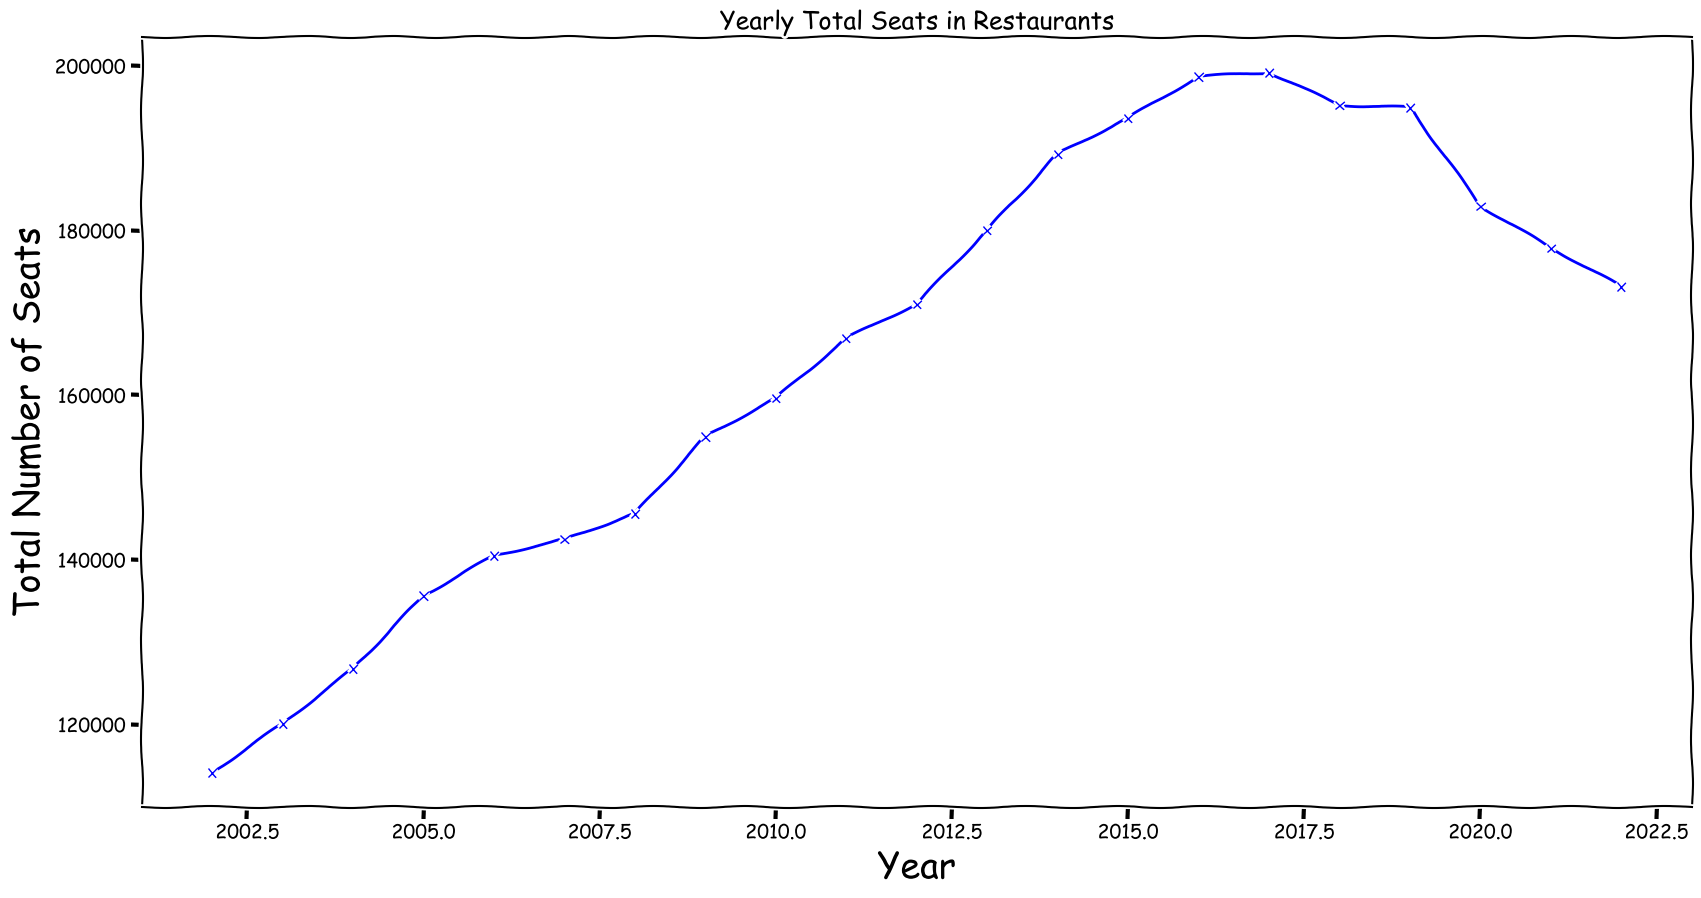

In [51]:
yearly_seats = data[["Census year", "Number of seats"]].groupby("Census year").sum()

plt.xkcd()

plt.plot(yearly_seats, "x-", color='blue')

plt.title("Yearly Total Seats in Restaurants", fontsize=18)
plt.xlabel("Year", fontsize=26)
plt.ylabel("Total Number of Seats", fontsize=26)

plt.grid(True)

plt.show()

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd S

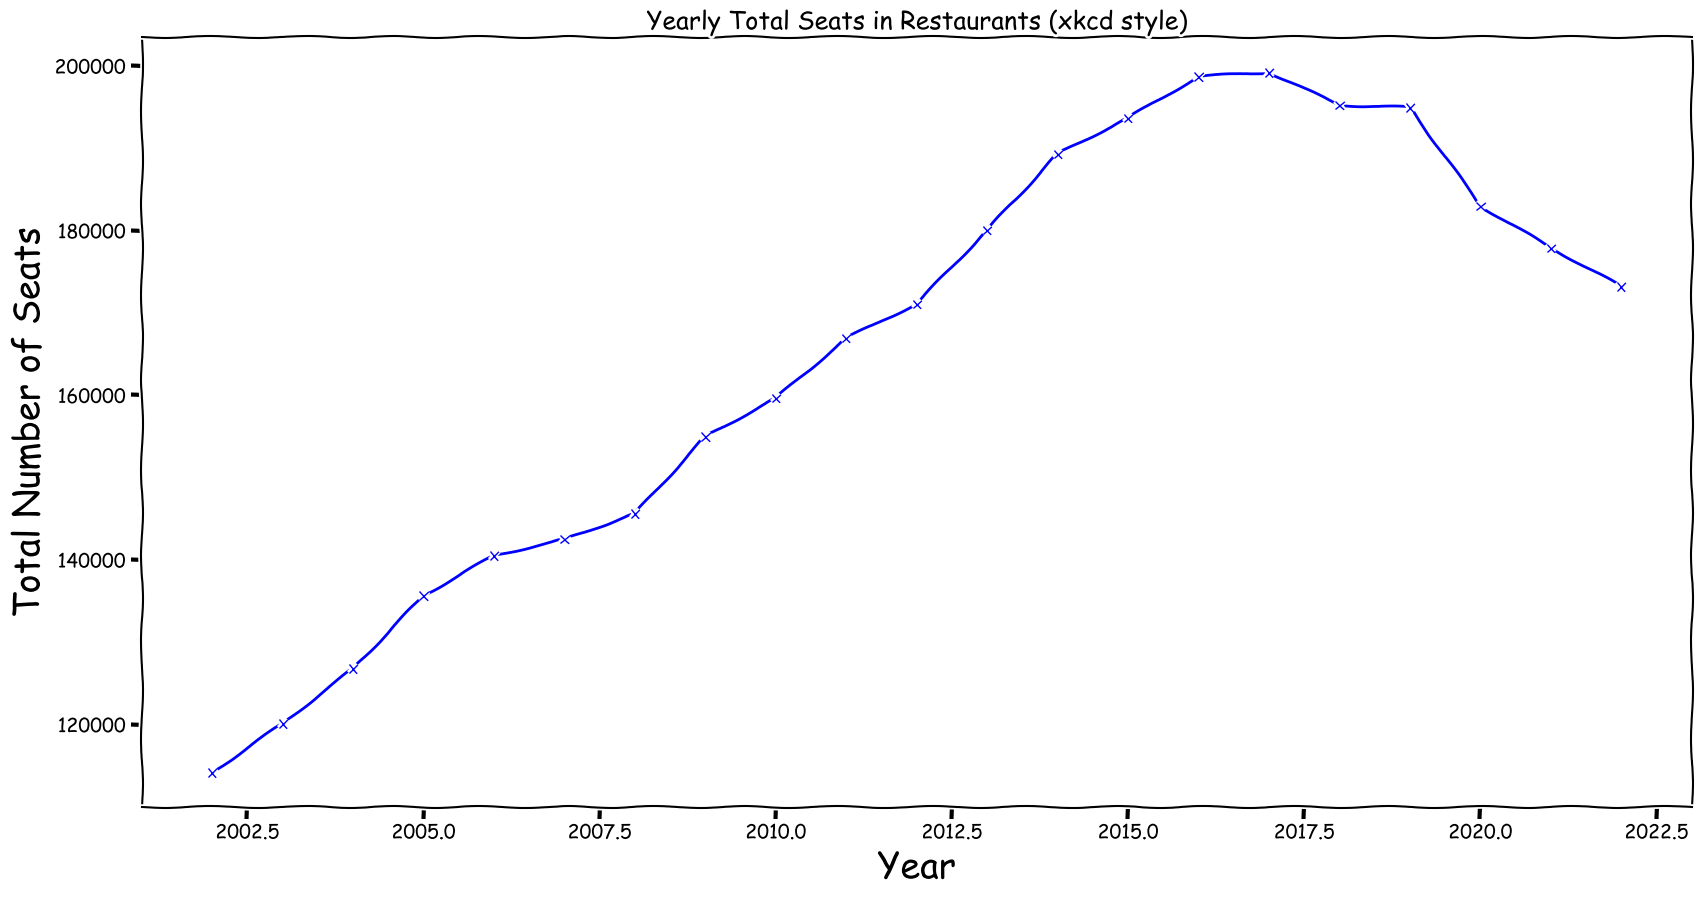

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd S

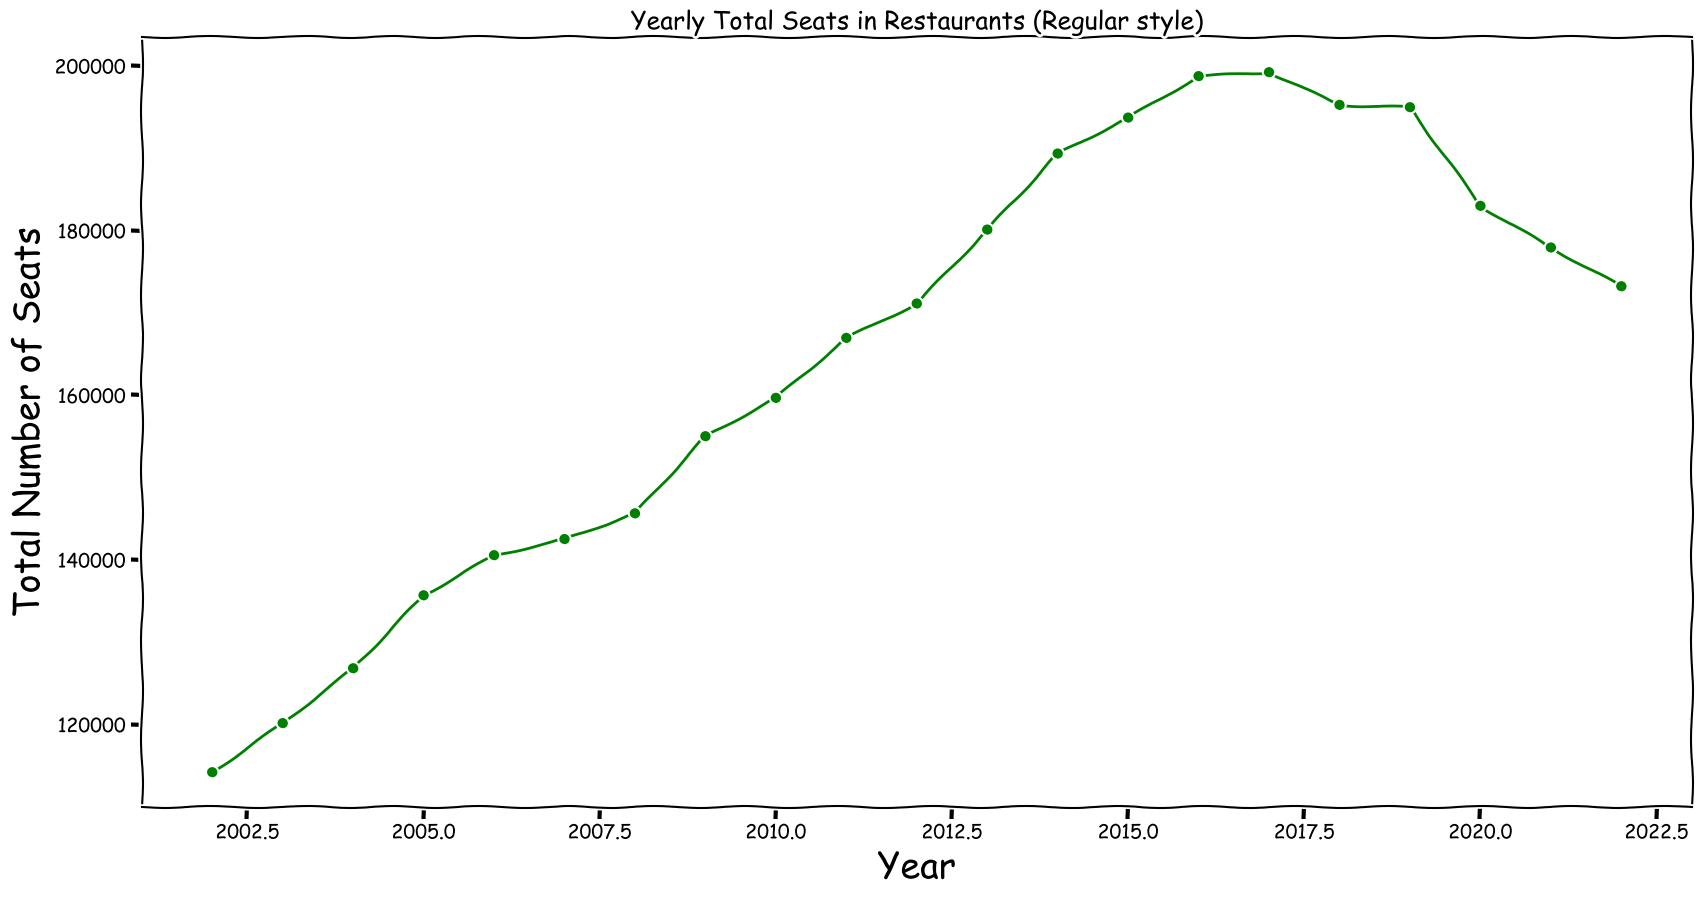

In [47]:
saved_style_state = matplotlib.rcParams.copy()

plt.xkcd()

yearly_seats = data[["Census year", "Number of seats"]].groupby("Census year").sum()
plt.plot(yearly_seats, "x-", color='blue')
plt.title("Yearly Total Seats in Restaurants (xkcd style)", fontsize=18)
plt.xlabel("Year", fontsize=26)
plt.ylabel("Total Number of Seats", fontsize=26)
plt.grid(True)
plt.show()

matplotlib.rcParams.update(saved_style_state)

plt.plot(yearly_seats, "o-", color='green')
plt.title("Yearly Total Seats in Restaurants (Regular style)", fontsize=18)
plt.xlabel("Year", fontsize=26)
plt.ylabel("Total Number of Seats", fontsize=26)
plt.grid(True)
plt.show()


The map of Melbourne

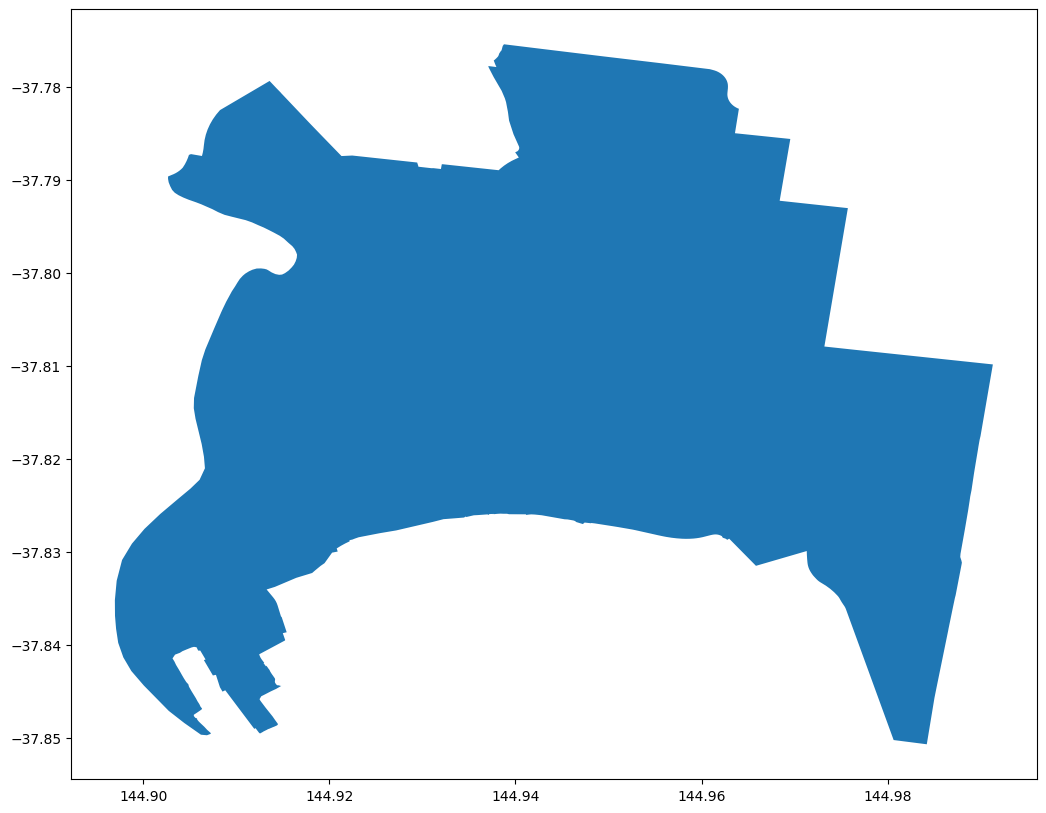

In [ ]:
burbs = gp.GeoDataFrame.from_file(shp_file_name)
burbs.set_crs(epsg=5234, inplace=True, allow_override=True) 
# https://epsg.io/8021
# GDA2020 is the latest and least wrong coord set for Sydney
ax = burbs.plot()

Locations of the restaurants and cafes

<Axes: >

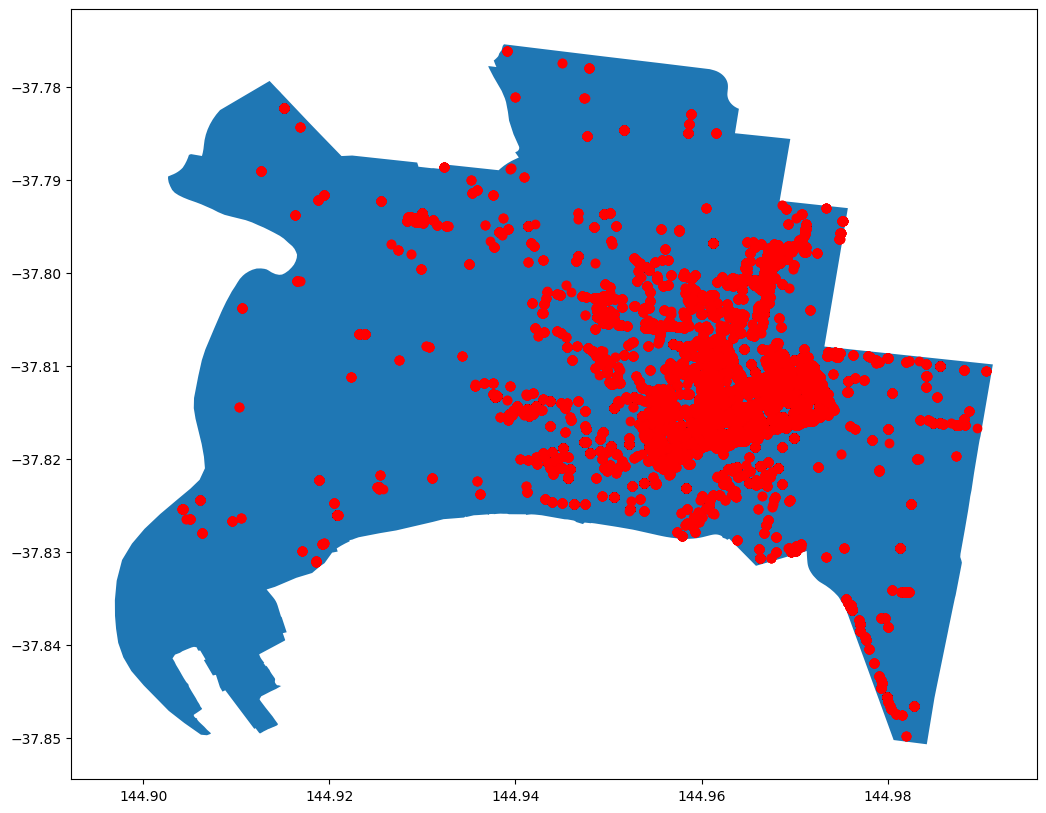

In [ ]:
seat_data["geometry"] = seat_data.apply(lambda row: shapely.geometry.point.Point(row.Longitude, row.Latitude),axis=1)
seat_data.head()

gdf = gp.GeoDataFrame(seat_data)
ax = burbs.plot()
gdf.plot(ax=ax, c="r")


findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd S

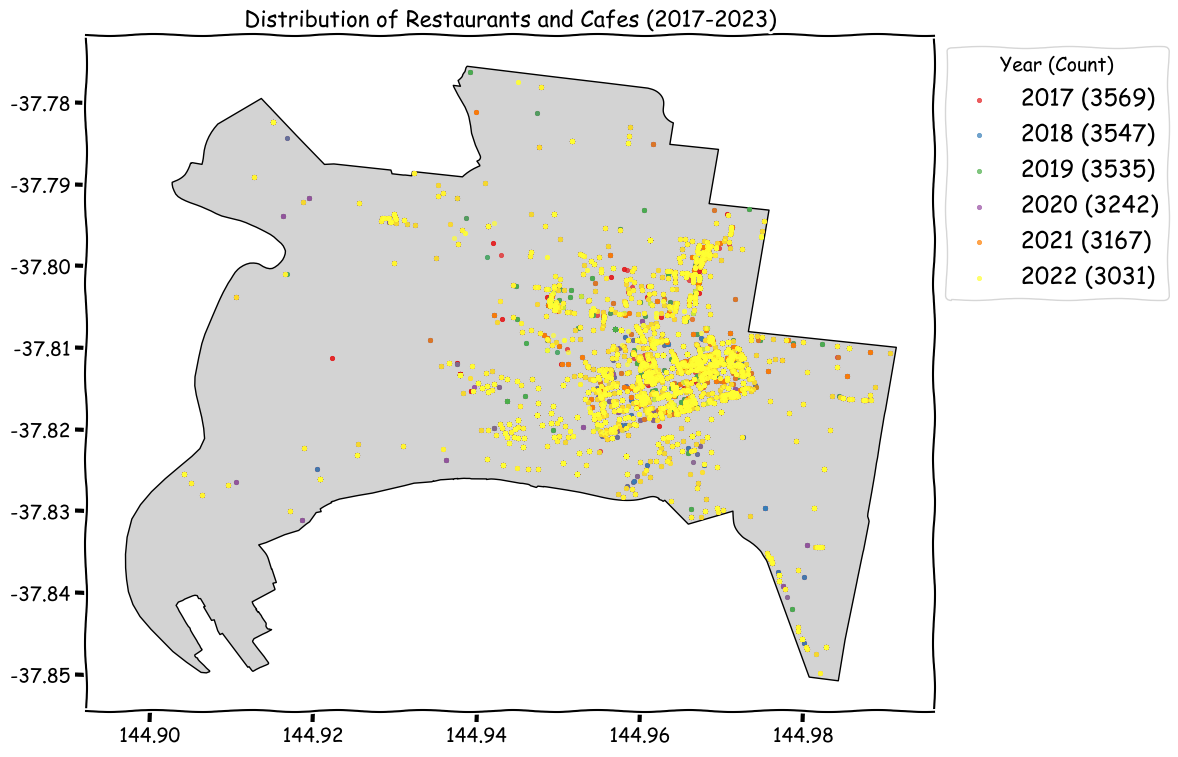

In [48]:
gdf = gp.GeoDataFrame(seat_data, geometry='geometry')

fig, ax = plt.subplots(figsize=(12, 12))
burbs.plot(ax=ax, color='lightgrey', edgecolor='black')  

colors = {
    2017: '#e41a1c',  
    2018: '#377eb8',  
    2019: '#4daf4a',  
    2020: '#984ea3',  
    2021: '#ff7f00',  
    2022: '#ffff33',  
    2023: '#a65628'   
}

for year in range(2017, 2024):
    yearly_data = gdf[gdf['Census year'] == year]
    yearly_data.plot(
        ax=ax, marker='o', color=colors[year], label=f"{year} ({len(yearly_data)})", 
        alpha=0.7, markersize=10, linewidth=0.5
    )

plt.legend(title="Year (Count)", loc='upper left', bbox_to_anchor=(1, 1), fontsize='large')
plt.title("Distribution of Restaurants and Cafes (2017-2023)", fontsize=16)
plt.tight_layout()
plt.show()

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd S

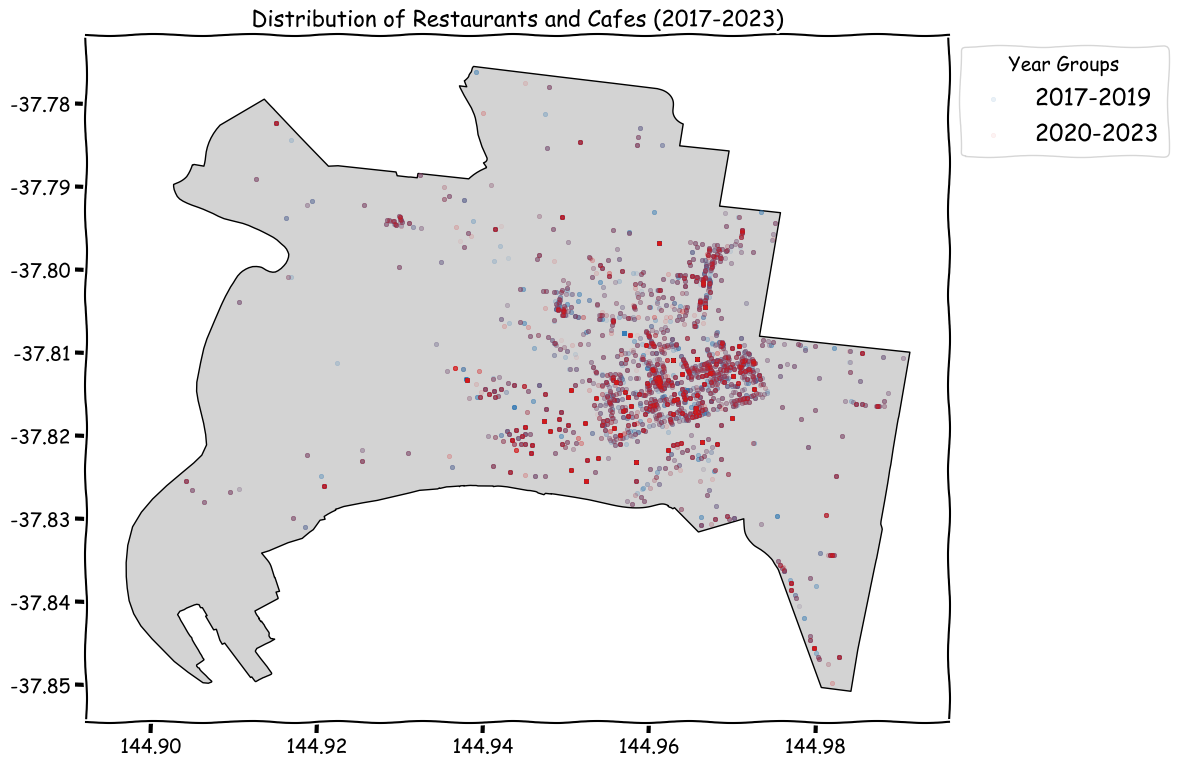

In [49]:
gdf = gp.GeoDataFrame(seat_data, geometry='geometry')

gdf = gdf[gdf['Census year'].between(2017, 2023)]

fig, ax = plt.subplots(figsize=(12, 12))
burbs.plot(ax=ax, color='lightgrey', edgecolor='black')  

early_years_color = '#377eb8' 
later_years_color = '#e41a1c' 
early_years_alpha = 0.1  
later_years_alpha = 0.05  

early_years_data = gdf[gdf['Census year'].between(2017, 2019)]
later_years_data = gdf[gdf['Census year'].between(2020, 2023)]

assert early_years_data['Census year'].min() >= 2017 and early_years_data['Census year'].max() <= 2019
assert later_years_data['Census year'].min() >= 2020 and later_years_data['Census year'].max() <= 2023

early_years_data.plot(
    ax=ax, marker='o', color=early_years_color, label="2017-2019", 
    alpha=early_years_alpha, markersize=10, linewidth=0.5
)

later_years_data.plot(
    ax=ax, marker='o', color=later_years_color, label="2020-2023", 
    alpha=later_years_alpha, markersize=10, linewidth=0.5
)

plt.legend(title="Year Groups", loc='upper left', bbox_to_anchor=(1, 1), fontsize='large')

plt.title("Distribution of Restaurants and Cafes (2017-2023)", fontsize=16)

plt.tight_layout()

plt.show()

The frequency of occurrence in each year

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd S

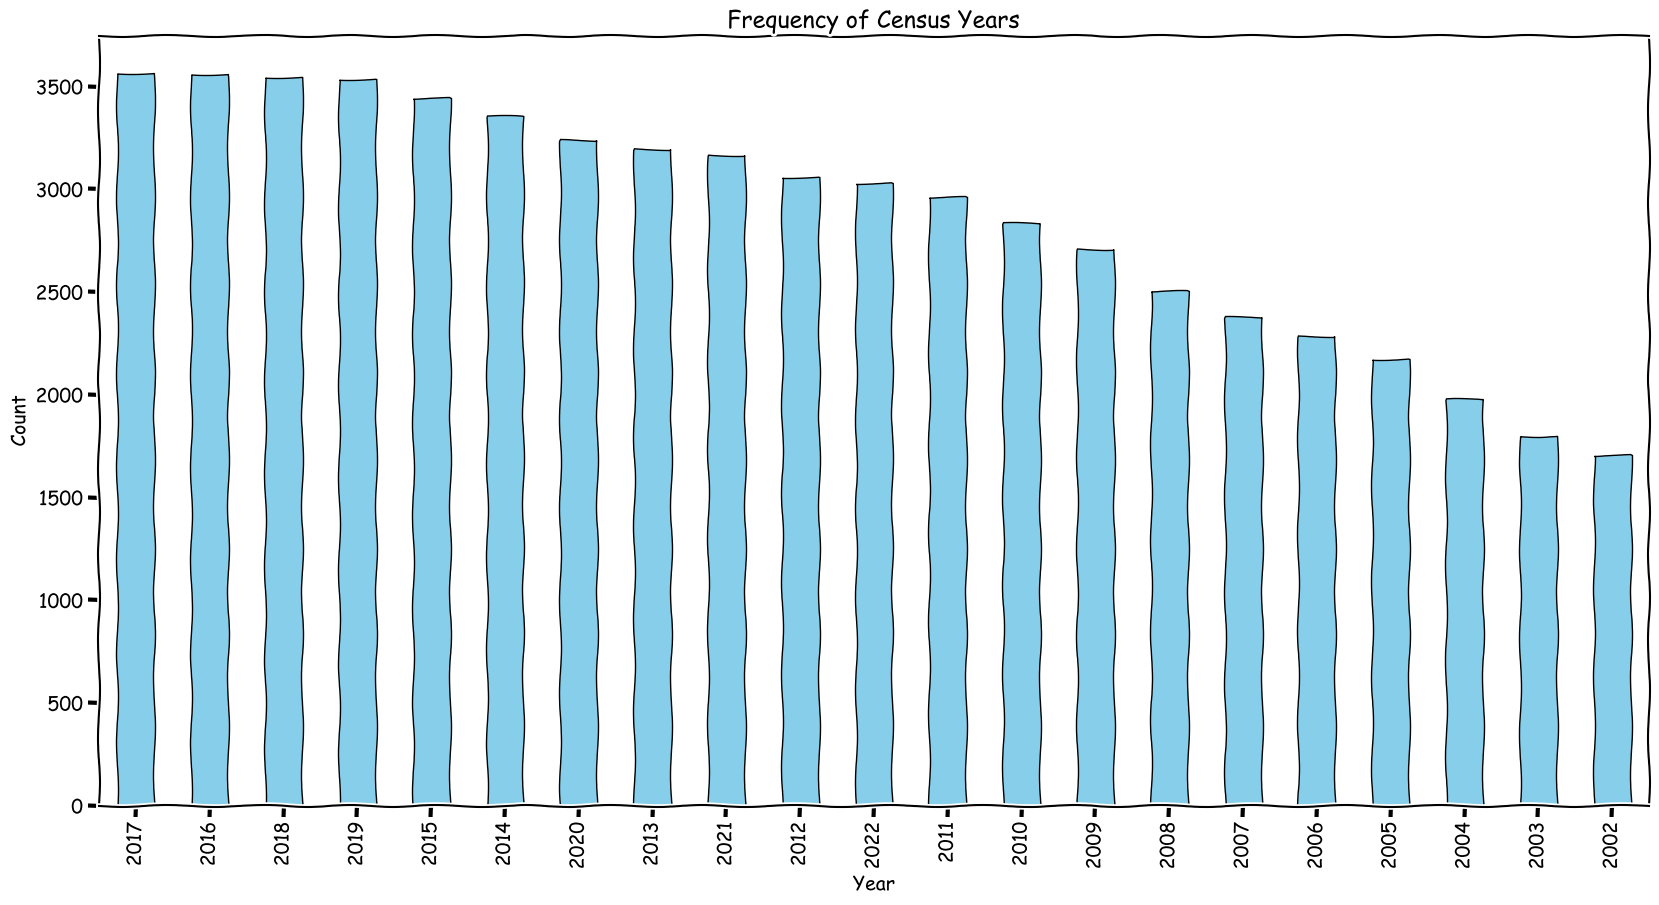

In [50]:
year_counts = seat_data['Census year'].value_counts()

year_counts.plot(kind="bar", color="skyblue", edgecolor="black")

plt.title("Frequency of Census Years")
plt.xlabel("Year")
plt.ylabel("Count")

plt.show()

# _fin_